In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
from PIL import Image
from PIL import ImageFile

In [2]:
import torch
import torch.nn as nn
from torch.nn import functional as F
from torch.utils.data import DataLoader, Dataset
from torchvision import models

import torchvision.transforms as transforms
import torchvision.datasets as datasets

In [3]:
from pytorch_grad_cam import GradCAM#, HiResCAM, ScoreCAM, GradCAMPlusPlus, AblationCAM, XGradCAM, EigenCAM, FullGrad
#from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image
#from torchvision.models import resnet50

In [4]:
import os
import time
from tqdm import tqdm
from sklearn.model_selection import train_test_split

In [5]:
from functions import(import_train_folder_dataset,
                      Data,
                      plot_loss_accuracy,
                      save_model,
                      save_metrics,
                      import_test_folder_dataset,
                      Data_test,
                      save_predictions_as_csv
                     )

In [6]:
import itertools

# Parameters

In [7]:
model_epochs = 250 # 100

lr = 0.006 # Learning rate.
                            
#torch.cuda.empty_cache()
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)


TRAIN_BATCH_SIZE = 8
TEST_BATCH_SIZE = 8

checkpoints_save = 50 # Save after 25 epochs
BBOX_THRESHOLD = 0.75 # From 0-1

model_checkpoints = "D:/Personal/Alex/Uni/MS IA/2 Curso/Fall 2022/Artificial Intelligence/Projects/Project 1/CheckPoints/"
PATH = "D:\\Personal\\Alex\\Uni\\MS IA\\2 Curso\\Fall 2022\Artificial Intelligence\\Projects\\Project 1\\Models Save\\CAM_Bbox_plus_Class\\"


cuda


# Import Data

In [8]:
# Path of the files
train_data_path = "D:/Personal/Alex/Uni/MS IA/2 Curso/Fall 2022/Artificial Intelligence/Projects/Project 1/data/Train"
test_data_path = "D:/Personal/Alex/Uni/MS IA/2 Curso/Fall 2022/Artificial Intelligence/Projects/Project 1/data/Test"

In [9]:
img_transform = transforms.Compose([transforms.ToPILImage(),
                                    transforms.RandomRotation((-20,20)),
                                    transforms.Resize((275, 275)),
                                    transforms.RandomCrop((224, 224)),
                                    transforms.RandomHorizontalFlip(),
                                    transforms.ToTensor(),
                                    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))])

img_transform_val = transforms.Compose([transforms.ToPILImage(),
                                        transforms.Resize((224, 224)),
                                        transforms.ToTensor(),
                                        transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))])

## Train-Val Data

In [10]:
# Import the data into a resized 224x224 images
size_of_resized_img = (275, 275) 
train_data, train_labels = import_train_folder_dataset(train_data_path, resized_side=size_of_resized_img)
print("Dim of Data: ", train_data.shape)
print("Dim of Lables: ", train_labels.shape)

Dim of Data:  (1149, 275, 275, 3)
Dim of Lables:  (1149,)


In [11]:
# Split into Train, Validation
X_train, X_val, y_train, y_val = train_test_split(train_data, train_labels, test_size=0.1, random_state=42)
print("Dim of Data: ", X_train.shape)
print("Dim of Lables: ", y_train.shape)
print("Dim of X_test: ", X_val.shape)
print("Dim of y_test: ", y_val.shape)

Dim of Data:  (1034, 275, 275, 3)
Dim of Lables:  (1034,)
Dim of X_test:  (115, 275, 275, 3)
Dim of y_test:  (115,)


In [12]:
# Create the dataset object
train_Dataset = Data(X_train, y_train, img_transform) # img_transform_2 img_transform
val_Dataset = Data(X_val, y_val, img_transform_val)

print("Train len: ",len(train_Dataset))
print("Val len: ",len(val_Dataset))

Train len:  1034
Val len:  115


In [13]:
# Create the dataloaders
train_loader = DataLoader(
    train_Dataset, 
    batch_size=TRAIN_BATCH_SIZE,             
    shuffle=True)

valid_loader = DataLoader(
    val_Dataset, 
    batch_size=TEST_BATCH_SIZE,
    shuffle=False
    )

# Create Model

### Model 1, to extract the BBOX

In [14]:
class Model_BBOX(nn.Module):
    def __init__(self):
        super(Model_BBOX, self).__init__()
        
        # get the pretrained resnet50 network
        self.resnet = models.resnet50(pretrained=True)
        
        # Create Last Layer
        self.last_classifier =  nn.Sequential(
                                            nn.ReLU(),
                                            nn.Linear(in_features=1000, out_features=4)
                                            )
        
    def forward(self, x):
        #print(x.shape)
        x = self.resnet(x)
        
        #print(x.shape)
        x = self.last_classifier(x)
        
        #print(x.shape)
        return x


# Create the model
model_bbox = Model_BBOX().to(device)

# Define the Target Layers, for CAM
target_layers = [model_bbox.resnet.layer4[-1]]

# Construct the CAM object once, and then re-use it on many images:
cam = GradCAM(model=model_bbox, target_layers=target_layers, use_cuda=torch.cuda.is_available())

# Loss Function
criterion = nn.CrossEntropyLoss()

# Optimizer
trainable_parameters_1 = filter(lambda p: p.requires_grad, model_bbox.parameters())
#optimizer = torch.optim.Adam(params=trainable_parameters_1, lr=lr)
optimizer = torch.optim.SGD(params=trainable_parameters_1, lr=lr, momentum=1e-5)  

# Check if checkpoint is available, if so, load it
model_epoch_m1_check = 0
previous_time = 0

model_bbox

D:\Users\Alex\anaconda3\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
D:\Users\Alex\anaconda3\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Model_BBOX(
  (resnet): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
        

In [15]:
# Check if checkpoint is available, if so, load it
model_epoch_m1_check = 0
previous_time = 0

names = os.listdir(model_checkpoints)
for elem in names:
    if(elem=="model_ckpt_m1.pth"):
        print("Loading save chackpoint")
        checkpoint = torch.load(model_checkpoints + "model_ckpt_m1.pth")
        model_bbox.load_state_dict(checkpoint['model_state_dict'])
        model_bbox.to(device)
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        model_epoch_m1_check = checkpoint['epoch']
        criterion = checkpoint['loss']
        previous_time = checkpoint['time']
        print(f"Epoch of the checkpoint: {model_epoch_m1_check}")

### Model 2, to make clasification

In [16]:
#PyTorch - Building the Model
class ClassificationNet(nn.Module):
    def __init__(self):
        super(ClassificationNet, self).__init__()
        # get the pretrained googlenet network
        self.googlenet = models.googlenet(pretrained=True)
        
        # Get the feature extractor
        self.googlenet_fe = nn.Sequential(*list(self.googlenet.children())[:-1])
        
        # Flatten the FE output
        self.flatten = nn.Flatten()
        
        # Add a clissifier
        self.last_classifier =  nn.Linear(in_features=1024, out_features=4)
        
        
    def forward(self, x): 
        x = self.googlenet_fe(x)
        
        x = self.flatten(x)
        
        x = self.last_classifier(x)
        
        return x

modelpy = ClassificationNet().to(device)

# Loss Function
criterion_2 = nn.CrossEntropyLoss()


# Train only the Classifiers
#trainable_parameters_2 = []
#for name, p in modelpy.named_parameters():
#    if "classifier" in name:
#        print(name)
#        trainable_parameters_2.append(p)

# Optimizer    
trainable_parameters_2 = filter(lambda p: p.requires_grad, modelpy.parameters())
#optimizer_2 = torch.optim.Adam(params=trainable_parameters_2, lr=lr)
optimizer_2 = torch.optim.SGD(params=trainable_parameters_2, lr=lr, momentum=1e-5) 

# Check if checkpoint is available, if so, load it
model_epoch_m2_check = 0
previous_time = 0

modelpy

D:\Users\Alex\anaconda3\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=GoogLeNet_Weights.IMAGENET1K_V1`. You can also use `weights=GoogLeNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


ClassificationNet(
  (googlenet): GoogLeNet(
    (conv1): BasicConv2d(
      (conv): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
    )
    (maxpool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
    (conv2): BasicConv2d(
      (conv): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
    )
    (conv3): BasicConv2d(
      (conv): Conv2d(64, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn): BatchNorm2d(192, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
    )
    (maxpool2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
    (inception3a): Inception(
      (branch1): BasicConv2d(
        (conv): Conv2d(192, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
   

In [17]:
# Check if checkpoint is available, if so, load it
model_epoch_m2_check = 0
previous_time = 0
names = os.listdir(model_checkpoints)
for elem in names:
    if(elem=="model_ckpt_m2.pth"):
        print("Loading save checkpoint")
        checkpoint = torch.load(model_checkpoints + "model_ckpt_m2.pth")
        modelpy.load_state_dict(checkpoint['model_state_dict'])
        modelpy.to(device)
        optimizer_2.load_state_dict(checkpoint['optimizer_state_dict'])
        model_epoch_m2_check = checkpoint['epoch']
        criterion_2 = checkpoint['loss']
        previous_time = checkpoint['time']
        print(f"Epoch of the checkpoint: {model_epoch_m2_check}")


# Functions for BBOX

In [18]:
def get_heatmap(image, device, cam_function):
    # You can also pass aug_smooth=True and eigen_smooth=True, to apply smoothing.
    grayscale_cam = cam_function(input_tensor=image.to(device), targets=None)

    return grayscale_cam

In [19]:
def bbox(heat_img, threshold, dim = (224,224)):
    H, W = heat_img.shape
    # Create Copy
    heat_2 = np.copy(heat_img)
    # Apply thershold
    heat_2[ heat_2 > threshold ] = 255
    heat_2[ heat_2 != 255 ] = 0
    
    up_bound_coord = -1
    down_bound_coord = -1
    for i in range(len(heat_2)):
        # Uper bound
        up_row = heat_2[i]
        if(up_bound_coord==-1 and 255 in up_row):
            # check if there is image in this row
            up_bound_coord = i
            
        # Lower bound
        low_row = heat_2[-(i+1)]
        if(down_bound_coord==-1 and 255 in low_row):
            # check if there is image in this row
            down_bound_coord = len(heat_2) - (i)
        
    left_bound_coord = -1
    right_bound_coord = -1
    for i in range(len(heat_2[0])):
        # left bound
        left_row = heat_2[:,i]
        if(left_bound_coord==-1 and 255 in left_row):
            # check if there is image in this row
            left_bound_coord = i
            
        # right bound
        right_row = heat_2[:,-(i+1)]
        if(right_bound_coord==-1 and 255 in right_row):
            # check if there is image in this row
            right_bound_coord = len(heat_2) - (i)
    
    return np.array([left_bound_coord*(dim[0]/H), up_bound_coord*(dim[1]/W), right_bound_coord*(dim[0]/H), down_bound_coord*(dim[1]/W)])



# Given a set of images, return the croped versions, based on the cams
def get_cropped_img_batch_base_on_CAM(batch, device, cam_function, threshold = 0.75):
    
    size = (batch.shape[2], batch.shape[3])
    
    
    heat_list = get_heatmap(batch, device, cam_function)
    
    outx = []
    for img, heat in zip(batch, heat_list):
        box = bbox(heat, threshold = threshold, dim = size)
        
        # Crop the Img
        img_crop = img[:,int(box[1]):int(box[3]), int(box[0]):int(box[2])]
        
        # Resize cropped img to original size
        rr = transforms.Compose([transforms.Resize(size)])
        img_resize = rr(img_crop)
        
        outx.append(img_resize)
    outx2 = torch.stack(outx, 0)
    return outx2

## Bbox Before Training

In [20]:
invTrans = transforms.Compose([ transforms.Normalize(mean = [ 0., 0., 0. ],
                                                     std = [ 1/0.229, 1/0.224, 1/0.225 ]),
                                transforms.Normalize(mean = [ -0.485, -0.456, -0.406 ],
                                                     std = [ 1., 1., 1. ]),
                               ])

In [21]:
# Use the model to make prediction on 1 sample. return the img, the real values and predictions
def get_true_values_and_predictions(model, t_Dataset, img_number, cam_function, threshold=0.75):
    # Make Prediction for Train Img
    model.eval()
    x_draw, y_draw_real = t_Dataset[img_number]

    # Invert norm of img, to plot it
    x_draw_inv = invTrans(x_draw)
    # Reorder the Axis
    x_draw_inv = np.moveaxis(x_draw_inv.numpy(), 0, -1)

    # Add dimension
    x_tensor = x_draw[None, :].to(device)
    
    # get the heatmap
    heat = get_heatmap(x_tensor, device, cam_function)[0]
    
    # calculate the bbox
    b_draw_pred = bbox(heat, threshold, dim = x_tensor.shape[2:4])
    
    print(f"Img shape: {x_draw_inv.shape}")

    print(f"Bbox pred: {b_draw_pred}")
    
    print(f"Label real: {y_draw_real.item()}")
        
    return x_draw_inv, y_draw_real.item(), heat, b_draw_pred


# Creates an Img with the Real BBOX and Label and another one with the predction BBOX and Label
def create_img_and_bbox_with_pred(img, pred_bbox):
    im = img.copy()
    im_cut = img.copy()
    
    print(f"Size of img: {im.shape}")
    # Add Bbox 
    real = cv2.rectangle(im, 
                         (int(pred_bbox[0]),int(pred_bbox[1])), 
                         (int(pred_bbox[2]-1),int(pred_bbox[3]-1)), 
                         (255, 0, 0), 2) #(0, 0, 255)
    
    # Crop the Img
    img_crop = im_cut[int(pred_bbox[1]):int(pred_bbox[3]), int(pred_bbox[0]):int(pred_bbox[2])]
    
    # Resize 
    resized_img_crop = cv2.resize(img_crop, (img.shape[0], img.shape[1]))
    
    return real, resized_img_crop

Img shape: (224, 224, 3)
Bbox pred: [ 96.   0. 145. 148.]
Label real: 1
Size of img: (224, 224, 3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


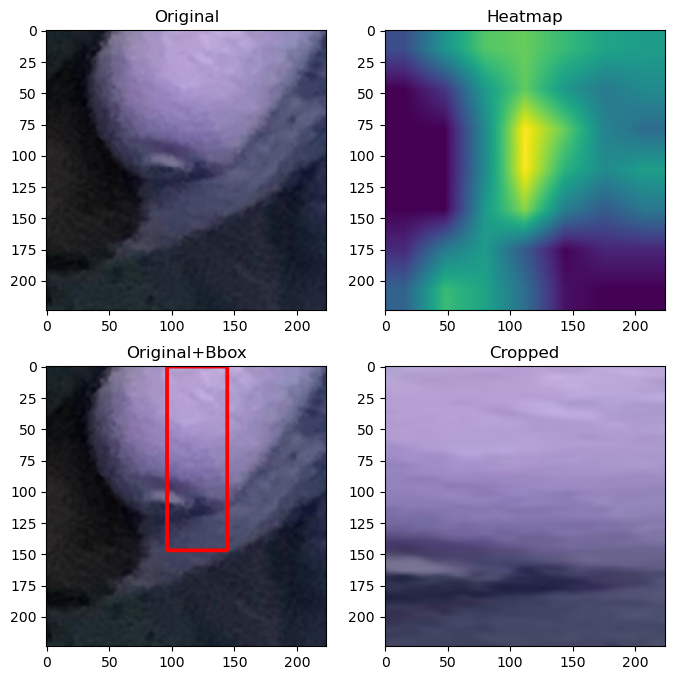

In [22]:
img_number = 1
# Create heatmap and Bbox
real_img, real_label, pred_heat, pred_box =get_true_values_and_predictions(model_bbox, val_Dataset, img_number, cam, threshold=BBOX_THRESHOLD)
# Compose img of real img+Bbox and croped Image
rr, rr_crop = create_img_and_bbox_with_pred(real_img, pred_box)

# Plot
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2,figsize=(8,8))
ax1.imshow(real_img)
ax1.title.set_text("Original")
ax2.imshow(pred_heat)
ax2.title.set_text("Heatmap")
ax3.imshow(rr)
ax3.title.set_text("Original+Bbox")
ax4.imshow(rr_crop)
ax4.title.set_text("Cropped")
plt.show()

# Train Model

In [23]:
def update_optimizer(optimizer, lr):
    for i, param_group in enumerate(optimizer.param_groups):
        param_group["lr"]=lr

Epoch 1 of 250


100%|██████████| 15/15 [00:05<00:00,  2.91it/s]


train loss:  0.14853277416247695
Val loss:  0.14439283661220384
train accuracy:  0.3994197292069632
Val accuracy:  0.4782608695652174
Current time: 1.935 minutes. Time expected till completion: 481.869 minutes
Epoch 2 of 250


100%|██████████| 15/15 [00:05<00:00,  2.94it/s]


train loss:  0.13562676616056282
Val loss:  0.13991476141888162
train accuracy:  0.5029013539651838
Val accuracy:  0.5478260869565217
Current time: 3.813 minutes. Time expected till completion: 472.842 minutes
Epoch 3 of 250


100%|██████████| 15/15 [00:05<00:00,  2.93it/s]


train loss:  0.1292995970184614
Val loss:  0.1363901340443155
train accuracy:  0.5319148936170213
Val accuracy:  0.6347826086956522
Current time: 5.670 minutes. Time expected till completion: 466.851 minutes
Epoch 4 of 250


100%|██████████| 15/15 [00:05<00:00,  2.96it/s]


train loss:  0.12308135749754177
Val loss:  0.13327804803848267
train accuracy:  0.5725338491295938
Val accuracy:  0.6695652173913044
Current time: 7.534 minutes. Time expected till completion: 463.316 minutes
Epoch 5 of 250


100%|██████████| 15/15 [00:05<00:00,  2.96it/s]


train loss:  0.1221784618998404
Val loss:  0.12616756895314094
train accuracy:  0.5822050290135397
Val accuracy:  0.6608695652173913
Current time: 9.389 minutes. Time expected till completion: 460.075 minutes
Epoch 6 of 250


100%|██████████| 15/15 [00:05<00:00,  2.98it/s]


train loss:  0.11907629579363294
Val loss:  0.12583972526633222
train accuracy:  0.5918762088974855
Val accuracy:  0.6608695652173913
Current time: 11.239 minutes. Time expected till completion: 457.040 minutes
Epoch 7 of 250


100%|██████████| 15/15 [00:05<00:00,  2.99it/s]


train loss:  0.11675332506805139
Val loss:  0.12454753336699112
train accuracy:  0.5870406189555126
Val accuracy:  0.6521739130434783
Current time: 13.086 minutes. Time expected till completion: 454.272 minutes
Epoch 8 of 250


100%|██████████| 15/15 [00:05<00:00,  2.97it/s]


train loss:  0.11553864362622598
Val loss:  0.1217759907245636
train accuracy:  0.6044487427466151
Val accuracy:  0.6608695652173913
Current time: 14.933 minutes. Time expected till completion: 451.712 minutes
Epoch 9 of 250


100%|██████████| 15/15 [00:05<00:00,  2.94it/s]


train loss:  0.11180906928715438
Val loss:  0.11839505226715752
train accuracy:  0.6189555125725339
Val accuracy:  0.6260869565217392
Current time: 16.781 minutes. Time expected till completion: 449.358 minutes
Epoch 10 of 250


100%|██████████| 15/15 [00:05<00:00,  2.97it/s]


train loss:  0.11039520687706465
Val loss:  0.11444221164869225
train accuracy:  0.6276595744680851
Val accuracy:  0.6608695652173913
Current time: 18.632 minutes. Time expected till completion: 447.167 minutes
Epoch 11 of 250


100%|██████████| 15/15 [00:05<00:00,  2.96it/s]


train loss:  0.11155621217459268
Val loss:  0.11505970903064894
train accuracy:  0.6121856866537717
Val accuracy:  0.6434782608695652
Current time: 20.481 minutes. Time expected till completion: 444.992 minutes
Epoch 12 of 250


100%|██████████| 15/15 [00:05<00:00,  2.96it/s]


train loss:  0.10752185455719783
Val loss:  0.11350524788317473
train accuracy:  0.6334622823984526
Val accuracy:  0.6782608695652174
Current time: 22.328 minutes. Time expected till completion: 442.839 minutes
Epoch 13 of 250


100%|██████████| 15/15 [00:05<00:00,  2.97it/s]


train loss:  0.1050525146826554
Val loss:  0.11501427422399106
train accuracy:  0.6576402321083172
Val accuracy:  0.6782608695652174
Current time: 24.176 minutes. Time expected till completion: 440.750 minutes
Epoch 14 of 250


100%|██████████| 15/15 [00:05<00:00,  2.96it/s]


train loss:  0.10452980641816063
Val loss:  0.1173208412916764
train accuracy:  0.6363636363636364
Val accuracy:  0.6782608695652174
Current time: 26.026 minutes. Time expected till completion: 438.719 minutes
Epoch 15 of 250


100%|██████████| 15/15 [00:05<00:00,  2.96it/s]


train loss:  0.1022699571843304
Val loss:  0.12201367979464324
train accuracy:  0.6624758220502901
Val accuracy:  0.6173913043478261
Current time: 27.874 minutes. Time expected till completion: 436.699 minutes
Epoch 16 of 250


100%|██████████| 15/15 [00:05<00:00,  2.95it/s]


train loss:  0.10127732546809103
Val loss:  0.11787904138150422
train accuracy:  0.6586073500967118
Val accuracy:  0.6695652173913044
Current time: 29.719 minutes. Time expected till completion: 434.647 minutes
Epoch 17 of 250


100%|██████████| 15/15 [00:05<00:00,  2.95it/s]


train loss:  0.1022963080865041
Val loss:  0.11141602785690971
train accuracy:  0.6518375241779497
Val accuracy:  0.6608695652173913
Current time: 31.566 minutes. Time expected till completion: 432.636 minutes
Epoch 18 of 250


100%|██████████| 15/15 [00:05<00:00,  2.96it/s]


train loss:  0.10087613392498784
Val loss:  0.11581708322400631
train accuracy:  0.6566731141199227
Val accuracy:  0.6695652173913044
Current time: 33.413 minutes. Time expected till completion: 430.658 minutes
Epoch 19 of 250


100%|██████████| 15/15 [00:05<00:00,  2.96it/s]


train loss:  0.09674396906300255
Val loss:  0.11841083687284719
train accuracy:  0.6769825918762089
Val accuracy:  0.6521739130434783
Current time: 35.259 minutes. Time expected till completion: 428.680 minutes
Epoch 20 of 250


100%|██████████| 15/15 [00:05<00:00,  2.97it/s]


train loss:  0.0990231137153489
Val loss:  0.10988885475241619
train accuracy:  0.6624758220502901
Val accuracy:  0.6521739130434783
Current time: 37.104 minutes. Time expected till completion: 426.701 minutes
Epoch 21 of 250


100%|██████████| 15/15 [00:05<00:00,  2.95it/s]


train loss:  0.09716874092990241
Val loss:  0.10880087795464889
train accuracy:  0.6798839458413927
Val accuracy:  0.6608695652173913
Current time: 38.951 minutes. Time expected till completion: 424.755 minutes
Epoch 22 of 250


100%|██████████| 15/15 [00:05<00:00,  2.98it/s]


train loss:  0.09614292037902072
Val loss:  0.1070394446020541
train accuracy:  0.6798839458413927
Val accuracy:  0.6782608695652174
Current time: 40.797 minutes. Time expected till completion: 422.809 minutes
Epoch 23 of 250


100%|██████████| 15/15 [00:05<00:00,  2.96it/s]


train loss:  0.09270152752242651
Val loss:  0.11484111055083897
train accuracy:  0.695357833655706
Val accuracy:  0.6521739130434783
Current time: 42.645 minutes. Time expected till completion: 420.885 minutes
Epoch 24 of 250


100%|██████████| 15/15 [00:05<00:00,  2.96it/s]


train loss:  0.09241801560847394
Val loss:  0.11627996123355368
train accuracy:  0.6895551257253385
Val accuracy:  0.6347826086956522
Current time: 44.491 minutes. Time expected till completion: 418.956 minutes
Epoch 25 of 250


100%|██████████| 15/15 [00:05<00:00,  2.96it/s]


train loss:  0.09317703184814011
Val loss:  0.11258284009021262
train accuracy:  0.6934235976789168
Val accuracy:  0.6260869565217392
Current time: 46.337 minutes. Time expected till completion: 417.037 minutes
Epoch 26 of 250


100%|██████████| 15/15 [00:05<00:00,  2.98it/s]


train loss:  0.09672948597017063
Val loss:  0.1153508818667868
train accuracy:  0.6827852998065764
Val accuracy:  0.5826086956521739
Current time: 48.184 minutes. Time expected till completion: 415.121 minutes
Epoch 27 of 250


100%|██████████| 15/15 [00:05<00:00,  2.96it/s]


train loss:  0.09044987525308155
Val loss:  0.11380796354749928
train accuracy:  0.6866537717601547
Val accuracy:  0.6260869565217392
Current time: 50.030 minutes. Time expected till completion: 413.212 minutes
Epoch 28 of 250


100%|██████████| 15/15 [00:05<00:00,  2.97it/s]


train loss:  0.08679909617919294
Val loss:  0.10920209159021792
train accuracy:  0.718568665377176
Val accuracy:  0.6347826086956522
Current time: 51.877 minutes. Time expected till completion: 411.308 minutes
Epoch 29 of 250


100%|██████████| 15/15 [00:05<00:00,  2.94it/s]


train loss:  0.08989118731344692
Val loss:  0.10877759197483892
train accuracy:  0.7001934235976789
Val accuracy:  0.6347826086956522
Current time: 53.724 minutes. Time expected till completion: 409.411 minutes
Epoch 30 of 250


100%|██████████| 15/15 [00:05<00:00,  2.95it/s]


train loss:  0.08917525404887688
Val loss:  0.10408238146616065
train accuracy:  0.6963249516441006
Val accuracy:  0.7043478260869566
Current time: 55.571 minutes. Time expected till completion: 407.520 minutes
Epoch 31 of 250


100%|██████████| 15/15 [00:05<00:00,  2.94it/s]


train loss:  0.08650605570762715
Val loss:  0.1018184218717658
train accuracy:  0.718568665377176
Val accuracy:  0.7043478260869566
Current time: 57.419 minutes. Time expected till completion: 405.635 minutes
Epoch 32 of 250


100%|██████████| 15/15 [00:05<00:00,  2.94it/s]


train loss:  0.08726373665049182
Val loss:  0.10908209837001304
train accuracy:  0.7117988394584139
Val accuracy:  0.6521739130434783
Current time: 59.267 minutes. Time expected till completion: 403.758 minutes
Epoch 33 of 250


100%|██████████| 15/15 [00:05<00:00,  2.94it/s]


train loss:  0.08561413723622346
Val loss:  0.10747190091920936
train accuracy:  0.7108317214700194
Val accuracy:  0.6956521739130435
Current time: 61.116 minutes. Time expected till completion: 401.885 minutes
Epoch 34 of 250


100%|██████████| 15/15 [00:05<00:00,  2.97it/s]


train loss:  0.08506078993616989
Val loss:  0.11006570121516353
train accuracy:  0.7137330754352031
Val accuracy:  0.7043478260869566
Current time: 62.965 minutes. Time expected till completion: 400.013 minutes
Epoch 35 of 250


100%|██████████| 15/15 [00:05<00:00,  2.97it/s]


train loss:  0.08640193815272827
Val loss:  0.10700569619303164
train accuracy:  0.7214700193423598
Val accuracy:  0.6260869565217392
Current time: 64.813 minutes. Time expected till completion: 398.139 minutes
Epoch 36 of 250


100%|██████████| 15/15 [00:05<00:00,  2.95it/s]


train loss:  0.08697079695631503
Val loss:  0.11018200957256814
train accuracy:  0.7030947775628626
Val accuracy:  0.6608695652173913
Current time: 66.661 minutes. Time expected till completion: 396.260 minutes
Epoch 37 of 250


100%|██████████| 15/15 [00:05<00:00,  2.97it/s]


train loss:  0.08332740686963559
Val loss:  0.10067910111468771
train accuracy:  0.7243713733075435
Val accuracy:  0.7217391304347827
Current time: 68.507 minutes. Time expected till completion: 394.377 minutes
Epoch 38 of 250


100%|██████████| 15/15 [00:05<00:00,  2.97it/s]


train loss:  0.08334051059627441
Val loss:  0.1009978597578795
train accuracy:  0.7340425531914894
Val accuracy:  0.7130434782608696
Current time: 70.352 minutes. Time expected till completion: 392.490 minutes
Epoch 39 of 250


100%|██████████| 15/15 [00:05<00:00,  2.92it/s]


train loss:  0.08160260305298597
Val loss:  0.10954269326251487
train accuracy:  0.7359767891682786
Val accuracy:  0.6608695652173913
Current time: 72.203 minutes. Time expected till completion: 390.635 minutes
Epoch 40 of 250


100%|██████████| 15/15 [00:05<00:00,  2.97it/s]


train loss:  0.08329579490642253
Val loss:  0.1046842634677887
train accuracy:  0.7321083172147002
Val accuracy:  0.7304347826086957
Current time: 74.054 minutes. Time expected till completion: 388.784 minutes
Epoch 41 of 250


100%|██████████| 15/15 [00:05<00:00,  2.97it/s]


train loss:  0.08106782758604858
Val loss:  0.10513063073158264
train accuracy:  0.7292069632495164
Val accuracy:  0.6695652173913044
Current time: 75.899 minutes. Time expected till completion: 386.902 minutes
Epoch 42 of 250


100%|██████████| 15/15 [00:05<00:00,  2.95it/s]


train loss:  0.08123255482148847
Val loss:  0.1026607386443926
train accuracy:  0.723404255319149
Val accuracy:  0.7304347826086957
Current time: 77.748 minutes. Time expected till completion: 385.036 minutes
Epoch 43 of 250


100%|██████████| 15/15 [00:05<00:00,  2.96it/s]


train loss:  0.0821716821314749
Val loss:  0.10998919139737669
train accuracy:  0.7214700193423598
Val accuracy:  0.6434782608695652
Current time: 79.594 minutes. Time expected till completion: 383.163 minutes
Epoch 44 of 250


100%|██████████| 15/15 [00:05<00:00,  2.95it/s]


train loss:  0.07950258144038788
Val loss:  0.11011260462843854
train accuracy:  0.7437137330754352
Val accuracy:  0.6869565217391305
Current time: 81.441 minutes. Time expected till completion: 381.290 minutes
Epoch 45 of 250


100%|██████████| 15/15 [00:05<00:00,  2.96it/s]


train loss:  0.07890181809779062
Val loss:  0.11309084425801816
train accuracy:  0.7321083172147002
Val accuracy:  0.6608695652173913
Current time: 83.287 minutes. Time expected till completion: 379.419 minutes
Epoch 46 of 250


100%|██████████| 15/15 [00:05<00:00,  2.95it/s]


train loss:  0.07661129917581953
Val loss:  0.10101421475410462
train accuracy:  0.7495164410058027
Val accuracy:  0.6695652173913044
Current time: 85.136 minutes. Time expected till completion: 377.559 minutes
Epoch 47 of 250


100%|██████████| 15/15 [00:05<00:00,  2.96it/s]


train loss:  0.07904681968331567
Val loss:  0.10558274725209112
train accuracy:  0.7446808510638298
Val accuracy:  0.7130434782608696
Current time: 86.985 minutes. Time expected till completion: 375.701 minutes
Epoch 48 of 250


100%|██████████| 15/15 [00:05<00:00,  2.95it/s]


train loss:  0.07735403357668126
Val loss:  0.11266609896784244
train accuracy:  0.7408123791102514
Val accuracy:  0.6782608695652174
Current time: 88.838 minutes. Time expected till completion: 373.860 minutes
Epoch 49 of 250


100%|██████████| 15/15 [00:05<00:00,  2.96it/s]


train loss:  0.08061073407732541
Val loss:  0.11001449952954831
train accuracy:  0.7398452611218569
Val accuracy:  0.6869565217391305
Current time: 90.688 minutes. Time expected till completion: 372.005 minutes
Epoch 50 of 250


100%|██████████| 15/15 [00:05<00:00,  2.94it/s]


train loss:  0.07796752083924108
Val loss:  0.1053844356018564
train accuracy:  0.758220502901354
Val accuracy:  0.7304347826086957
Saving model 1 checkpoint
Saving model 2 checkpoint


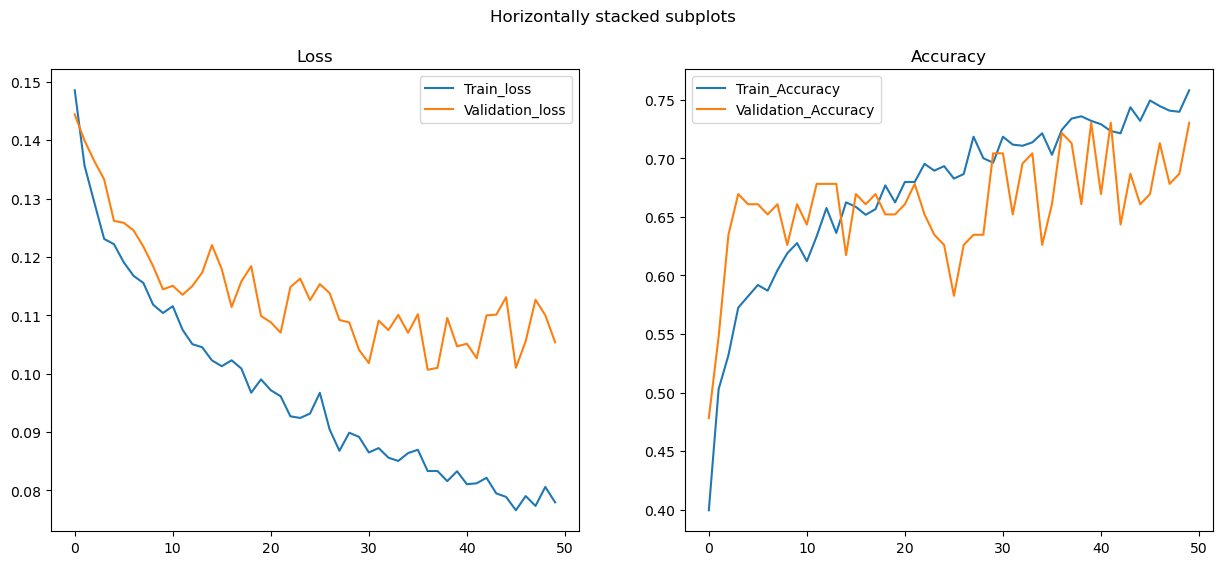

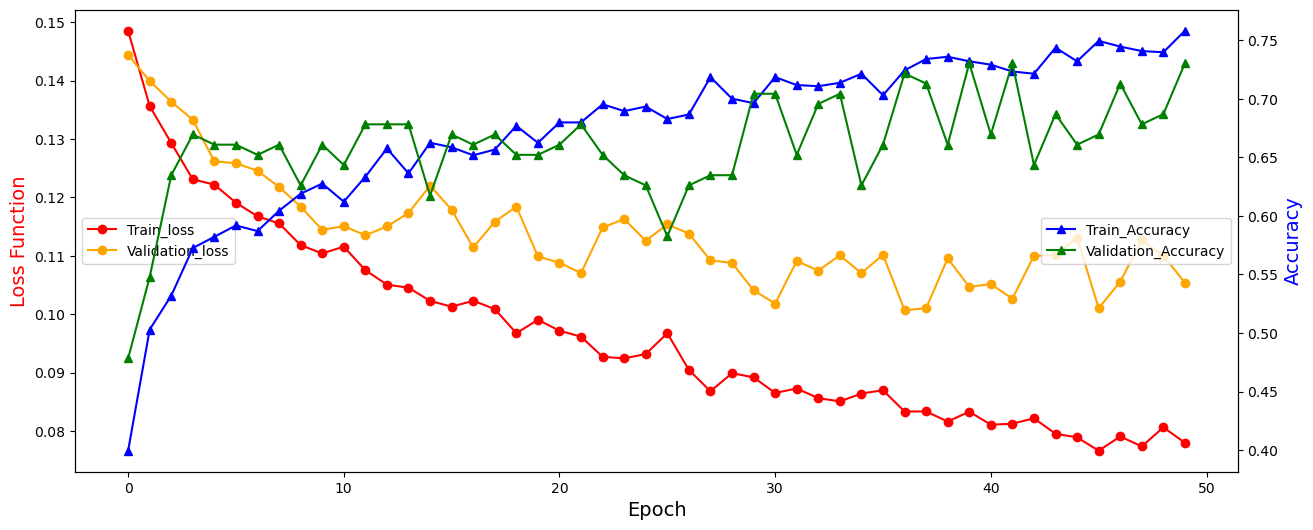

Current time: 92.673 minutes. Time expected till completion: 370.693 minutes
Epoch 51 of 250


100%|██████████| 15/15 [00:05<00:00,  2.89it/s]


train loss:  0.07531563578825624
Val loss:  0.12243132383927055
train accuracy:  0.7514506769825918
Val accuracy:  0.6434782608695652
Current time: 94.529 minutes. Time expected till completion: 368.848 minutes
Epoch 52 of 250


100%|██████████| 15/15 [00:05<00:00,  2.94it/s]


train loss:  0.07663979933271095
Val loss:  0.10779669906782068
train accuracy:  0.741779497098646
Val accuracy:  0.6782608695652174
Current time: 96.380 minutes. Time expected till completion: 366.986 minutes
Epoch 53 of 250


100%|██████████| 15/15 [00:05<00:00,  2.95it/s]


train loss:  0.07656469165817681
Val loss:  0.11249232784561489
train accuracy:  0.7553191489361702
Val accuracy:  0.6347826086956522
Current time: 98.228 minutes. Time expected till completion: 365.111 minutes
Epoch 54 of 250


100%|██████████| 15/15 [00:05<00:00,  2.94it/s]


train loss:  0.07235597777297464
Val loss:  0.11147856090379799
train accuracy:  0.7630560928433269
Val accuracy:  0.6869565217391305
Current time: 100.074 minutes. Time expected till completion: 363.231 minutes
Epoch 55 of 250


100%|██████████| 15/15 [00:05<00:00,  2.96it/s]


train loss:  0.07637184394282114
Val loss:  0.1175996500512828
train accuracy:  0.7359767891682786
Val accuracy:  0.6608695652173913
Current time: 101.921 minutes. Time expected till completion: 361.355 minutes
Epoch 56 of 250


100%|██████████| 15/15 [00:05<00:00,  2.97it/s]


train loss:  0.07585413078101969
Val loss:  0.12570732831954956
train accuracy:  0.7678916827852998
Val accuracy:  0.6782608695652174
Current time: 103.767 minutes. Time expected till completion: 359.480 minutes
Epoch 57 of 250


100%|██████████| 15/15 [00:05<00:00,  2.97it/s]


train loss:  0.07403295454019734
Val loss:  0.10995263839545458
train accuracy:  0.758220502901354
Val accuracy:  0.7130434782608696
Current time: 105.614 minutes. Time expected till completion: 357.604 minutes
Epoch 58 of 250


100%|██████████| 15/15 [00:05<00:00,  2.98it/s]


train loss:  0.07443276657299562
Val loss:  0.11497997447200443
train accuracy:  0.7640232108317214
Val accuracy:  0.6869565217391305
Current time: 107.460 minutes. Time expected till completion: 355.731 minutes
Epoch 59 of 250


100%|██████████| 15/15 [00:05<00:00,  2.97it/s]


train loss:  0.07771068992997507
Val loss:  0.112137153096821
train accuracy:  0.7359767891682786
Val accuracy:  0.6260869565217392
Current time: 109.306 minutes. Time expected till completion: 353.856 minutes
Epoch 60 of 250


100%|██████████| 15/15 [00:05<00:00,  2.91it/s]


train loss:  0.07266908316247929
Val loss:  0.10645757784014163
train accuracy:  0.7601547388781431
Val accuracy:  0.6608695652173913
Current time: 111.154 minutes. Time expected till completion: 351.987 minutes
Epoch 61 of 250


100%|██████████| 15/15 [00:05<00:00,  2.98it/s]


train loss:  0.0714661922716541
Val loss:  0.1064667170462401
train accuracy:  0.7727272727272727
Val accuracy:  0.6608695652173913
Current time: 113.001 minutes. Time expected till completion: 350.118 minutes
Epoch 62 of 250


100%|██████████| 15/15 [00:05<00:00,  2.98it/s]


train loss:  0.06827233011187622
Val loss:  0.10553926916226097
train accuracy:  0.7852998065764023
Val accuracy:  0.7043478260869566
Current time: 114.847 minutes. Time expected till completion: 348.245 minutes
Epoch 63 of 250


100%|██████████| 15/15 [00:05<00:00,  2.97it/s]


train loss:  0.07261343738442463
Val loss:  0.10967336037884588
train accuracy:  0.7611218568665378
Val accuracy:  0.7043478260869566
Current time: 116.693 minutes. Time expected till completion: 346.375 minutes
Epoch 64 of 250


100%|██████████| 15/15 [00:05<00:00,  2.95it/s]


train loss:  0.07224371687759513
Val loss:  0.10961759971535724
train accuracy:  0.7678916827852998
Val accuracy:  0.6695652173913044
Current time: 118.540 minutes. Time expected till completion: 344.507 minutes
Epoch 65 of 250


100%|██████████| 15/15 [00:05<00:00,  2.94it/s]


train loss:  0.06962362221465582
Val loss:  0.10890973262164903
train accuracy:  0.7794970986460348
Val accuracy:  0.6695652173913044
Current time: 120.386 minutes. Time expected till completion: 342.638 minutes
Epoch 66 of 250


100%|██████████| 15/15 [00:05<00:00,  2.94it/s]


train loss:  0.06722337060843953
Val loss:  0.0977728536595469
train accuracy:  0.776595744680851
Val accuracy:  0.6956521739130435
Current time: 122.233 minutes. Time expected till completion: 340.771 minutes
Epoch 67 of 250


100%|██████████| 15/15 [00:05<00:00,  2.92it/s]


train loss:  0.06839351351706156
Val loss:  0.10612420802531035
train accuracy:  0.7940038684719536
Val accuracy:  0.7130434782608696
Current time: 124.080 minutes. Time expected till completion: 338.904 minutes
Epoch 68 of 250


100%|██████████| 15/15 [00:05<00:00,  2.96it/s]


train loss:  0.07063590746726012
Val loss:  0.1114318671433822
train accuracy:  0.7717601547388782
Val accuracy:  0.6869565217391305
Current time: 125.927 minutes. Time expected till completion: 337.039 minutes
Epoch 69 of 250


100%|██████████| 15/15 [00:05<00:00,  2.98it/s]


train loss:  0.06704089999544782
Val loss:  0.1156986960898275
train accuracy:  0.8065764023210832
Val accuracy:  0.7043478260869566
Current time: 127.775 minutes. Time expected till completion: 335.178 minutes
Epoch 70 of 250


100%|██████████| 15/15 [00:05<00:00,  2.97it/s]


train loss:  0.07025759430814758
Val loss:  0.1058189560537753
train accuracy:  0.776595744680851
Val accuracy:  0.7130434782608696
Current time: 129.623 minutes. Time expected till completion: 333.315 minutes
Epoch 71 of 250


100%|██████████| 15/15 [00:05<00:00,  2.95it/s]


train loss:  0.06525699825997049
Val loss:  0.10831342520921126
train accuracy:  0.7978723404255319
Val accuracy:  0.7043478260869566
Current time: 131.469 minutes. Time expected till completion: 331.451 minutes
Epoch 72 of 250


100%|██████████| 15/15 [00:05<00:00,  2.98it/s]


train loss:  0.06989431290435145
Val loss:  0.10665255007536514
train accuracy:  0.7678916827852998
Val accuracy:  0.6956521739130435
Current time: 133.314 minutes. Time expected till completion: 329.583 minutes
Epoch 73 of 250


100%|██████████| 15/15 [00:05<00:00,  2.97it/s]


train loss:  0.07152870656270353
Val loss:  0.10025861353977866
train accuracy:  0.7785299806576402
Val accuracy:  0.7217391304347827
Current time: 135.159 minutes. Time expected till completion: 327.715 minutes
Epoch 74 of 250


100%|██████████| 15/15 [00:05<00:00,  2.94it/s]


train loss:  0.06915483213024398
Val loss:  0.11330943133520044
train accuracy:  0.7872340425531915
Val accuracy:  0.6521739130434783
Current time: 137.008 minutes. Time expected till completion: 325.856 minutes
Epoch 75 of 250


100%|██████████| 15/15 [00:05<00:00,  2.97it/s]


train loss:  0.06442184749147647
Val loss:  0.11536274630090465
train accuracy:  0.8056092843326886
Val accuracy:  0.6956521739130435
Current time: 138.856 minutes. Time expected till completion: 323.998 minutes
Epoch 76 of 250


100%|██████████| 15/15 [00:05<00:00,  2.96it/s]


train loss:  0.07049413536976108
Val loss:  0.12027322753616002
train accuracy:  0.769825918762089
Val accuracy:  0.6608695652173913
Current time: 140.703 minutes. Time expected till completion: 322.137 minutes
Epoch 77 of 250


100%|██████████| 15/15 [00:05<00:00,  2.93it/s]


train loss:  0.0656872113997286
Val loss:  0.10890794318655263
train accuracy:  0.7949709864603481
Val accuracy:  0.6782608695652174
Current time: 142.551 minutes. Time expected till completion: 320.278 minutes
Epoch 78 of 250


100%|██████████| 15/15 [00:05<00:00,  2.94it/s]


train loss:  0.06279469324668556
Val loss:  0.1167537694391997
train accuracy:  0.7978723404255319
Val accuracy:  0.6782608695652174
Current time: 144.401 minutes. Time expected till completion: 318.422 minutes
Epoch 79 of 250


100%|██████████| 15/15 [00:05<00:00,  2.96it/s]


train loss:  0.06419704531677918
Val loss:  0.12443239481552787
train accuracy:  0.7969052224371374
Val accuracy:  0.6695652173913044
Current time: 146.251 minutes. Time expected till completion: 316.569 minutes
Epoch 80 of 250


100%|██████████| 15/15 [00:05<00:00,  2.95it/s]


train loss:  0.06304719889215851
Val loss:  0.10418526335902836
train accuracy:  0.8085106382978723
Val accuracy:  0.7304347826086957
Current time: 148.103 minutes. Time expected till completion: 314.718 minutes
Epoch 81 of 250


100%|██████████| 15/15 [00:05<00:00,  2.95it/s]


train loss:  0.07026211701953204
Val loss:  0.11847238436989162
train accuracy:  0.7649903288201161
Val accuracy:  0.6869565217391305
Current time: 149.952 minutes. Time expected till completion: 312.863 minutes
Epoch 82 of 250


100%|██████████| 15/15 [00:05<00:00,  2.95it/s]


train loss:  0.06309022951143392
Val loss:  0.10508731409259464
train accuracy:  0.8065764023210832
Val accuracy:  0.7391304347826086
Current time: 151.802 minutes. Time expected till completion: 311.008 minutes
Epoch 83 of 250


100%|██████████| 15/15 [00:05<00:00,  2.95it/s]


train loss:  0.06722171327218096
Val loss:  0.11578945400922194
train accuracy:  0.7852998065764023
Val accuracy:  0.7043478260869566
Current time: 153.651 minutes. Time expected till completion: 309.154 minutes
Epoch 84 of 250


100%|██████████| 15/15 [00:05<00:00,  2.96it/s]


train loss:  0.06443195112006346
Val loss:  0.12838476015173872
train accuracy:  0.8007736943907157
Val accuracy:  0.6608695652173913
Current time: 155.501 minutes. Time expected till completion: 307.299 minutes
Epoch 85 of 250


100%|██████████| 15/15 [00:05<00:00,  2.95it/s]


train loss:  0.0691914742009091
Val loss:  0.11161476840143618
train accuracy:  0.7959381044487428
Val accuracy:  0.6608695652173913
Current time: 157.350 minutes. Time expected till completion: 305.444 minutes
Epoch 86 of 250


100%|██████████| 15/15 [00:05<00:00,  2.96it/s]


train loss:  0.06457510741870684
Val loss:  0.10458977326102879
train accuracy:  0.8104448742746615
Val accuracy:  0.6608695652173913
Current time: 159.200 minutes. Time expected till completion: 303.590 minutes
Epoch 87 of 250


100%|██████████| 15/15 [00:05<00:00,  2.96it/s]


train loss:  0.06233021922452768
Val loss:  0.10596912347752115
train accuracy:  0.8017408123791102
Val accuracy:  0.6869565217391305
Current time: 161.048 minutes. Time expected till completion: 301.734 minutes
Epoch 88 of 250


100%|██████████| 15/15 [00:05<00:00,  2.97it/s]


train loss:  0.06282430682583519
Val loss:  0.11442008588625037
train accuracy:  0.8017408123791102
Val accuracy:  0.6347826086956522
Current time: 162.894 minutes. Time expected till completion: 299.874 minutes
Epoch 89 of 250


100%|██████████| 15/15 [00:05<00:00,  2.96it/s]


train loss:  0.060370263692200526
Val loss:  0.11149164541907933
train accuracy:  0.8056092843326886
Val accuracy:  0.6695652173913044
Current time: 164.742 minutes. Time expected till completion: 298.016 minutes
Epoch 90 of 250


100%|██████████| 15/15 [00:05<00:00,  2.95it/s]


train loss:  0.0662648331813471
Val loss:  0.11835945909437925
train accuracy:  0.804642166344294
Val accuracy:  0.6608695652173913
Current time: 166.588 minutes. Time expected till completion: 296.156 minutes
Epoch 91 of 250


100%|██████████| 15/15 [00:05<00:00,  2.96it/s]


train loss:  0.06205004191375563
Val loss:  0.10072096327076788
train accuracy:  0.793036750483559
Val accuracy:  0.6869565217391305
Current time: 168.435 minutes. Time expected till completion: 294.299 minutes
Epoch 92 of 250


100%|██████████| 15/15 [00:05<00:00,  2.95it/s]


train loss:  0.06033234891969876
Val loss:  0.1018572281236234
train accuracy:  0.8065764023210832
Val accuracy:  0.6695652173913044
Current time: 170.281 minutes. Time expected till completion: 292.440 minutes
Epoch 93 of 250


100%|██████████| 15/15 [00:05<00:00,  2.94it/s]


train loss:  0.0577088833446083
Val loss:  0.10156557119410971
train accuracy:  0.8085106382978723
Val accuracy:  0.7304347826086957
Current time: 172.128 minutes. Time expected till completion: 290.582 minutes
Epoch 94 of 250


100%|██████████| 15/15 [00:05<00:00,  2.96it/s]


train loss:  0.057459604564326416
Val loss:  0.10640834906826849
train accuracy:  0.8239845261121856
Val accuracy:  0.6695652173913044
Current time: 173.975 minutes. Time expected till completion: 288.725 minutes
Epoch 95 of 250


100%|██████████| 15/15 [00:05<00:00,  2.94it/s]


train loss:  0.06354539713153987
Val loss:  0.10439159377761509
train accuracy:  0.7862669245647969
Val accuracy:  0.6956521739130435
Current time: 175.823 minutes. Time expected till completion: 286.869 minutes
Epoch 96 of 250


100%|██████████| 15/15 [00:05<00:00,  2.93it/s]


train loss:  0.05677414098952679
Val loss:  0.11661556596341341
train accuracy:  0.8268858800773694
Val accuracy:  0.6956521739130435
Current time: 177.672 minutes. Time expected till completion: 285.015 minutes
Epoch 97 of 250


100%|██████████| 15/15 [00:05<00:00,  2.98it/s]


train loss:  0.05483543842569772
Val loss:  0.11505083519479503
train accuracy:  0.8307543520309478
Val accuracy:  0.6173913043478261
Current time: 179.519 minutes. Time expected till completion: 283.159 minutes
Epoch 98 of 250


100%|██████████| 15/15 [00:05<00:00,  2.96it/s]


train loss:  0.05952377378854115
Val loss:  0.10197912998821425
train accuracy:  0.8085106382978723
Val accuracy:  0.7217391304347827
Current time: 181.365 minutes. Time expected till completion: 281.301 minutes
Epoch 99 of 250


100%|██████████| 15/15 [00:05<00:00,  2.96it/s]


train loss:  0.06037194417281584
Val loss:  0.12352109784665315
train accuracy:  0.8085106382978723
Val accuracy:  0.6695652173913044
Current time: 183.212 minutes. Time expected till completion: 279.445 minutes
Epoch 100 of 250


100%|██████████| 15/15 [00:05<00:00,  2.95it/s]


train loss:  0.05574889267061619
Val loss:  0.11093797891036324
train accuracy:  0.8365570599613152
Val accuracy:  0.7043478260869566
Saving model 1 checkpoint
Saving model 2 checkpoint


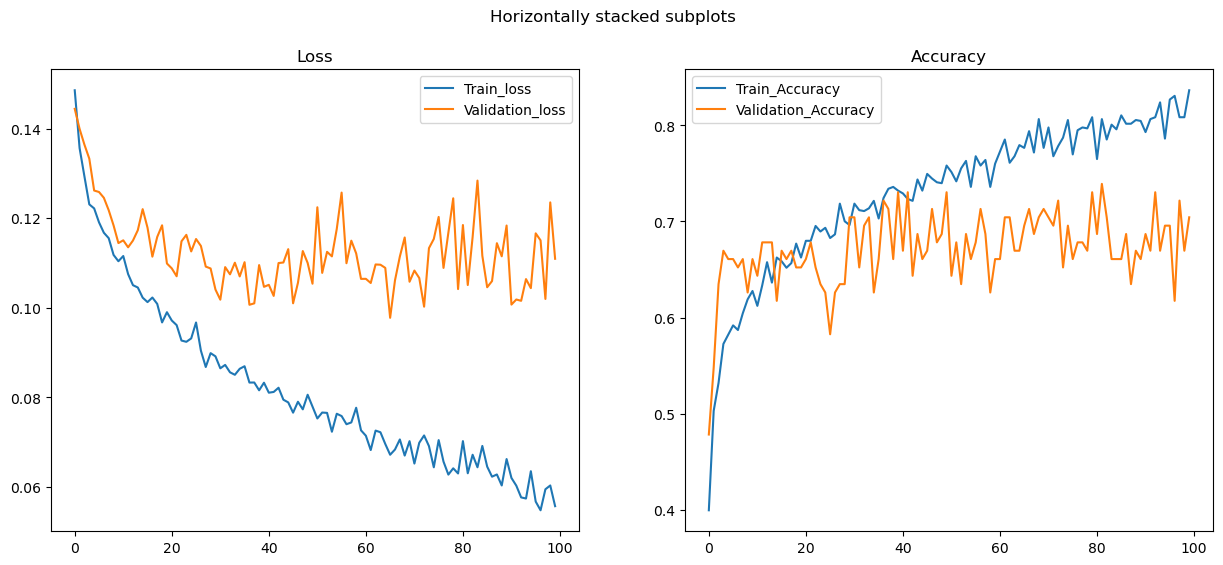

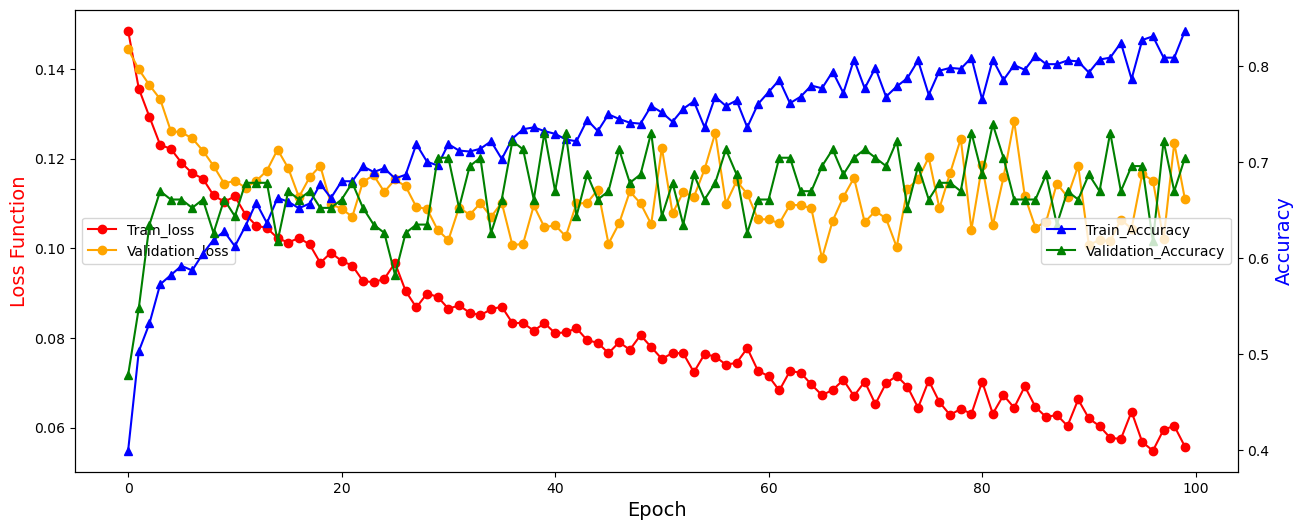

Current time: 185.117 minutes. Time expected till completion: 277.676 minutes
Epoch 101 of 250


100%|██████████| 15/15 [00:05<00:00,  2.96it/s]


train loss:  0.05489163511438112
Val loss:  0.12106016006158746
train accuracy:  0.8278529980657641
Val accuracy:  0.6173913043478261
Current time: 186.968 minutes. Time expected till completion: 275.824 minutes
Epoch 102 of 250


100%|██████████| 15/15 [00:05<00:00,  2.95it/s]


train loss:  0.059596442586852226
Val loss:  0.12510799454606097
train accuracy:  0.8065764023210832
Val accuracy:  0.6608695652173913
Current time: 188.815 minutes. Time expected till completion: 273.967 minutes
Epoch 103 of 250


100%|██████████| 15/15 [00:05<00:00,  2.97it/s]


train loss:  0.05734049564144598
Val loss:  0.11888248376224352
train accuracy:  0.8027079303675049
Val accuracy:  0.6434782608695652
Current time: 190.664 minutes. Time expected till completion: 272.112 minutes
Epoch 104 of 250


100%|██████████| 15/15 [00:05<00:00,  2.97it/s]


train loss:  0.05465784212808544
Val loss:  0.11488465770431187
train accuracy:  0.8210831721470019
Val accuracy:  0.6869565217391305
Current time: 192.512 minutes. Time expected till completion: 270.257 minutes
Epoch 105 of 250


100%|██████████| 15/15 [00:05<00:00,  2.95it/s]


train loss:  0.05950373519262447
Val loss:  0.10874583358350007
train accuracy:  0.8191489361702128
Val accuracy:  0.6869565217391305
Current time: 194.362 minutes. Time expected till completion: 268.404 minutes
Epoch 106 of 250


100%|██████████| 15/15 [00:05<00:00,  2.97it/s]


train loss:  0.05764474708233857
Val loss:  0.11378270607927571
train accuracy:  0.8259187620889749
Val accuracy:  0.6695652173913044
Current time: 196.211 minutes. Time expected till completion: 266.550 minutes
Epoch 107 of 250


100%|██████████| 15/15 [00:05<00:00,  2.95it/s]


train loss:  0.0573400206056854
Val loss:  0.09970245646393817
train accuracy:  0.8268858800773694
Val accuracy:  0.6695652173913044
Current time: 198.061 minutes. Time expected till completion: 264.699 minutes
Epoch 108 of 250


100%|██████████| 15/15 [00:05<00:00,  2.95it/s]


train loss:  0.05408523191393459
Val loss:  0.11324712660001672
train accuracy:  0.8326885880077369
Val accuracy:  0.6956521739130435
Current time: 199.911 minutes. Time expected till completion: 262.846 minutes
Epoch 109 of 250


100%|██████████| 15/15 [00:05<00:00,  2.95it/s]


train loss:  0.05543632433538972
Val loss:  0.1167007943858271
train accuracy:  0.8317214700193424
Val accuracy:  0.6869565217391305
Current time: 201.761 minutes. Time expected till completion: 260.993 minutes
Epoch 110 of 250


100%|██████████| 15/15 [00:05<00:00,  2.93it/s]


train loss:  0.05374626810995707
Val loss:  0.11259612583595774
train accuracy:  0.8384912959381045
Val accuracy:  0.6608695652173913
Current time: 203.610 minutes. Time expected till completion: 259.140 minutes
Epoch 111 of 250


100%|██████████| 15/15 [00:05<00:00,  2.94it/s]


train loss:  0.05662087761081856
Val loss:  0.11649069656496462
train accuracy:  0.8239845261121856
Val accuracy:  0.6782608695652174
Current time: 205.459 minutes. Time expected till completion: 257.287 minutes
Epoch 112 of 250


100%|██████████| 15/15 [00:05<00:00,  2.92it/s]


train loss:  0.054531653964715494
Val loss:  0.11125712239223978
train accuracy:  0.8230174081237911
Val accuracy:  0.6782608695652174
Current time: 207.309 minutes. Time expected till completion: 255.434 minutes
Epoch 113 of 250


100%|██████████| 15/15 [00:05<00:00,  2.95it/s]


train loss:  0.05107656557912753
Val loss:  0.11454742887745732
train accuracy:  0.8500967117988395
Val accuracy:  0.6695652173913044
Current time: 209.154 minutes. Time expected till completion: 253.577 minutes
Epoch 114 of 250


100%|██████████| 15/15 [00:05<00:00,  2.95it/s]


train loss:  0.053398848999457384
Val loss:  0.11202367129533188
train accuracy:  0.8268858800773694
Val accuracy:  0.6869565217391305
Current time: 211.002 minutes. Time expected till completion: 251.722 minutes
Epoch 115 of 250


100%|██████████| 15/15 [00:05<00:00,  2.96it/s]


train loss:  0.052256678222053515
Val loss:  0.1175095216087673
train accuracy:  0.8375241779497099
Val accuracy:  0.6434782608695652
Current time: 212.850 minutes. Time expected till completion: 249.867 minutes
Epoch 116 of 250


100%|██████████| 15/15 [00:05<00:00,  2.98it/s]


train loss:  0.05148996583526554
Val loss:  0.12146194940027984
train accuracy:  0.8375241779497099
Val accuracy:  0.6434782608695652
Current time: 214.695 minutes. Time expected till completion: 248.010 minutes
Epoch 117 of 250


100%|██████████| 15/15 [00:05<00:00,  2.96it/s]


train loss:  0.052952263698817684
Val loss:  0.11946190206900886
train accuracy:  0.8307543520309478
Val accuracy:  0.6869565217391305
Current time: 216.541 minutes. Time expected till completion: 246.154 minutes
Epoch 118 of 250


100%|██████████| 15/15 [00:05<00:00,  2.97it/s]


train loss:  0.05369206878934884
Val loss:  0.1176009344018024
train accuracy:  0.8288201160541586
Val accuracy:  0.6521739130434783
Current time: 218.387 minutes. Time expected till completion: 244.297 minutes
Epoch 119 of 250


100%|██████████| 15/15 [00:05<00:00,  2.96it/s]


train loss:  0.053185080781550195
Val loss:  0.11815730048262554
train accuracy:  0.8307543520309478
Val accuracy:  0.6956521739130435
Current time: 220.234 minutes. Time expected till completion: 242.442 minutes
Epoch 120 of 250


100%|██████████| 15/15 [00:05<00:00,  2.96it/s]


train loss:  0.050789884077222944
Val loss:  0.11403685989587203
train accuracy:  0.8462282398452611
Val accuracy:  0.6956521739130435
Current time: 222.080 minutes. Time expected till completion: 240.587 minutes
Epoch 121 of 250


100%|██████████| 15/15 [00:05<00:00,  2.97it/s]


train loss:  0.05552050541200075
Val loss:  0.11127458914466526
train accuracy:  0.8307543520309478
Val accuracy:  0.6869565217391305
Current time: 223.925 minutes. Time expected till completion: 238.730 minutes
Epoch 122 of 250


100%|██████████| 15/15 [00:05<00:00,  2.98it/s]


train loss:  0.053374651855495496
Val loss:  0.1070889079052469
train accuracy:  0.839458413926499
Val accuracy:  0.7130434782608696
Current time: 225.772 minutes. Time expected till completion: 236.875 minutes
Epoch 123 of 250


100%|██████████| 15/15 [00:05<00:00,  2.95it/s]


train loss:  0.0505638066931435
Val loss:  0.12476084880206896
train accuracy:  0.851063829787234
Val accuracy:  0.6434782608695652
Current time: 227.624 minutes. Time expected till completion: 235.026 minutes
Epoch 124 of 250


100%|██████████| 15/15 [00:05<00:00,  2.96it/s]


train loss:  0.046579080747307156
Val loss:  0.11172949697660363
train accuracy:  0.8626692456479691
Val accuracy:  0.6869565217391305
Current time: 229.471 minutes. Time expected till completion: 233.172 minutes
Epoch 125 of 250


100%|██████████| 15/15 [00:05<00:00,  2.96it/s]


train loss:  0.04994761270814984
Val loss:  0.11542195418606634
train accuracy:  0.8481624758220503
Val accuracy:  0.6782608695652174
Current time: 231.319 minutes. Time expected till completion: 231.319 minutes
Epoch 126 of 250


100%|██████████| 15/15 [00:05<00:00,  2.95it/s]


train loss:  0.04703655844370563
Val loss:  0.11900362709294195
train accuracy:  0.8520309477756286
Val accuracy:  0.6782608695652174
Current time: 233.167 minutes. Time expected till completion: 229.465 minutes
Epoch 127 of 250


100%|██████████| 15/15 [00:05<00:00,  2.95it/s]


train loss:  0.05600773284438731
Val loss:  0.11599709210188493
train accuracy:  0.8346228239845261
Val accuracy:  0.6521739130434783
Current time: 235.014 minutes. Time expected till completion: 227.612 minutes
Epoch 128 of 250


100%|██████████| 15/15 [00:05<00:00,  2.95it/s]


train loss:  0.04899452560053457
Val loss:  0.11495299144931462
train accuracy:  0.8462282398452611
Val accuracy:  0.7130434782608696
Current time: 236.860 minutes. Time expected till completion: 225.757 minutes
Epoch 129 of 250


100%|██████████| 15/15 [00:05<00:00,  2.97it/s]


train loss:  0.04903699566449833
Val loss:  0.11597202640512715
train accuracy:  0.8578336557059961
Val accuracy:  0.6608695652173913
Current time: 238.708 minutes. Time expected till completion: 223.904 minutes
Epoch 130 of 250


100%|██████████| 15/15 [00:05<00:00,  2.96it/s]


train loss:  0.05054788540767747
Val loss:  0.12116870374783226
train accuracy:  0.8423597678916828
Val accuracy:  0.6695652173913044
Current time: 240.556 minutes. Time expected till completion: 222.051 minutes
Epoch 131 of 250


100%|██████████| 15/15 [00:05<00:00,  2.96it/s]


train loss:  0.05217780078431624
Val loss:  0.1292149165402288
train accuracy:  0.8423597678916828
Val accuracy:  0.6260869565217392
Current time: 242.404 minutes. Time expected till completion: 220.199 minutes
Epoch 132 of 250


100%|██████████| 15/15 [00:05<00:00,  2.97it/s]


train loss:  0.04966336602932365
Val loss:  0.12324094694593678
train accuracy:  0.851063829787234
Val accuracy:  0.6608695652173913
Current time: 244.251 minutes. Time expected till completion: 218.346 minutes
Epoch 133 of 250


100%|██████████| 15/15 [00:05<00:00,  2.97it/s]


train loss:  0.0466875643676554
Val loss:  0.10670503870300625
train accuracy:  0.8549323017408124
Val accuracy:  0.7217391304347827
Current time: 246.099 minutes. Time expected till completion: 216.493 minutes
Epoch 134 of 250


100%|██████████| 15/15 [00:05<00:00,  2.97it/s]


train loss:  0.050270112162920676
Val loss:  0.10123974965966266
train accuracy:  0.8481624758220503
Val accuracy:  0.7304347826086957
Current time: 247.946 minutes. Time expected till completion: 214.640 minutes
Epoch 135 of 250


100%|██████████| 15/15 [00:05<00:00,  2.97it/s]


train loss:  0.047808734851401136
Val loss:  0.11220382141030354
train accuracy:  0.8481624758220503
Val accuracy:  0.6869565217391305
Current time: 249.793 minutes. Time expected till completion: 212.787 minutes
Epoch 136 of 250


100%|██████████| 15/15 [00:05<00:00,  2.97it/s]


train loss:  0.047915678312803835
Val loss:  0.11750529771265776
train accuracy:  0.8462282398452611
Val accuracy:  0.6608695652173913
Current time: 251.641 minutes. Time expected till completion: 210.934 minutes
Epoch 137 of 250


100%|██████████| 15/15 [00:05<00:00,  2.96it/s]


train loss:  0.04705766517834691
Val loss:  0.1201647946368093
train accuracy:  0.8617021276595744
Val accuracy:  0.6608695652173913
Current time: 253.487 minutes. Time expected till completion: 209.081 minutes
Epoch 138 of 250


100%|██████████| 15/15 [00:05<00:00,  2.96it/s]


train loss:  0.04674722581410085
Val loss:  0.1195144798444665
train accuracy:  0.8539651837524178
Val accuracy:  0.7130434782608696
Current time: 255.336 minutes. Time expected till completion: 207.229 minutes
Epoch 139 of 250


100%|██████████| 15/15 [00:05<00:00,  2.91it/s]


train loss:  0.05041915808067562
Val loss:  0.10197476090296455
train accuracy:  0.8539651837524178
Val accuracy:  0.7304347826086957
Current time: 257.184 minutes. Time expected till completion: 205.377 minutes
Epoch 140 of 250


100%|██████████| 15/15 [00:05<00:00,  2.93it/s]


train loss:  0.04557973582016545
Val loss:  0.10388262725394705
train accuracy:  0.8578336557059961
Val accuracy:  0.7391304347826086
Current time: 259.032 minutes. Time expected till completion: 203.525 minutes
Epoch 141 of 250


100%|██████████| 15/15 [00:05<00:00,  2.93it/s]


train loss:  0.04786699446822504
Val loss:  0.10336350409880929
train accuracy:  0.8713733075435203
Val accuracy:  0.7391304347826086
Current time: 260.880 minutes. Time expected till completion: 201.674 minutes
Epoch 142 of 250


100%|██████████| 15/15 [00:05<00:00,  2.96it/s]


train loss:  0.042575175225432076
Val loss:  0.10675150920515475
train accuracy:  0.874274661508704
Val accuracy:  0.6869565217391305
Current time: 262.728 minutes. Time expected till completion: 199.822 minutes
Epoch 143 of 250


100%|██████████| 15/15 [00:05<00:00,  2.98it/s]


train loss:  0.047980363821210896
Val loss:  0.1108174530060395
train accuracy:  0.8597678916827853
Val accuracy:  0.7391304347826086
Current time: 264.575 minutes. Time expected till completion: 197.969 minutes
Epoch 144 of 250


100%|██████████| 15/15 [00:05<00:00,  2.98it/s]


train loss:  0.04239558634605813
Val loss:  0.0964325276405915
train accuracy:  0.874274661508704
Val accuracy:  0.7652173913043478
Current time: 266.422 minutes. Time expected till completion: 196.116 minutes
Epoch 145 of 250


100%|██████████| 15/15 [00:05<00:00,  2.97it/s]


train loss:  0.0484763802942501
Val loss:  0.11694439882817476
train accuracy:  0.8500967117988395
Val accuracy:  0.7217391304347827
Current time: 268.270 minutes. Time expected till completion: 194.265 minutes
Epoch 146 of 250


100%|██████████| 15/15 [00:05<00:00,  2.97it/s]


train loss:  0.044786043584029725
Val loss:  0.11879137313884237
train accuracy:  0.8588007736943907
Val accuracy:  0.7043478260869566
Current time: 270.118 minutes. Time expected till completion: 192.413 minutes
Epoch 147 of 250


100%|██████████| 15/15 [00:05<00:00,  2.96it/s]


train loss:  0.040882256314360196
Val loss:  0.11521376760109611
train accuracy:  0.8713733075435203
Val accuracy:  0.6869565217391305
Current time: 271.966 minutes. Time expected till completion: 190.561 minutes
Epoch 148 of 250


100%|██████████| 15/15 [00:05<00:00,  2.96it/s]


train loss:  0.04385005080319466
Val loss:  0.10980943817159404
train accuracy:  0.874274661508704
Val accuracy:  0.7217391304347827
Current time: 273.815 minutes. Time expected till completion: 188.710 minutes
Epoch 149 of 250


100%|██████████| 15/15 [00:05<00:00,  2.95it/s]


train loss:  0.043040547784727705
Val loss:  0.12563082731288414
train accuracy:  0.8655705996131529
Val accuracy:  0.6434782608695652
Current time: 275.664 minutes. Time expected till completion: 186.860 minutes
Epoch 150 of 250


100%|██████████| 15/15 [00:05<00:00,  2.94it/s]


train loss:  0.04380530387710787
Val loss:  0.12738441721252772
train accuracy:  0.8733075435203095
Val accuracy:  0.6869565217391305
Saving model 1 checkpoint
Saving model 2 checkpoint


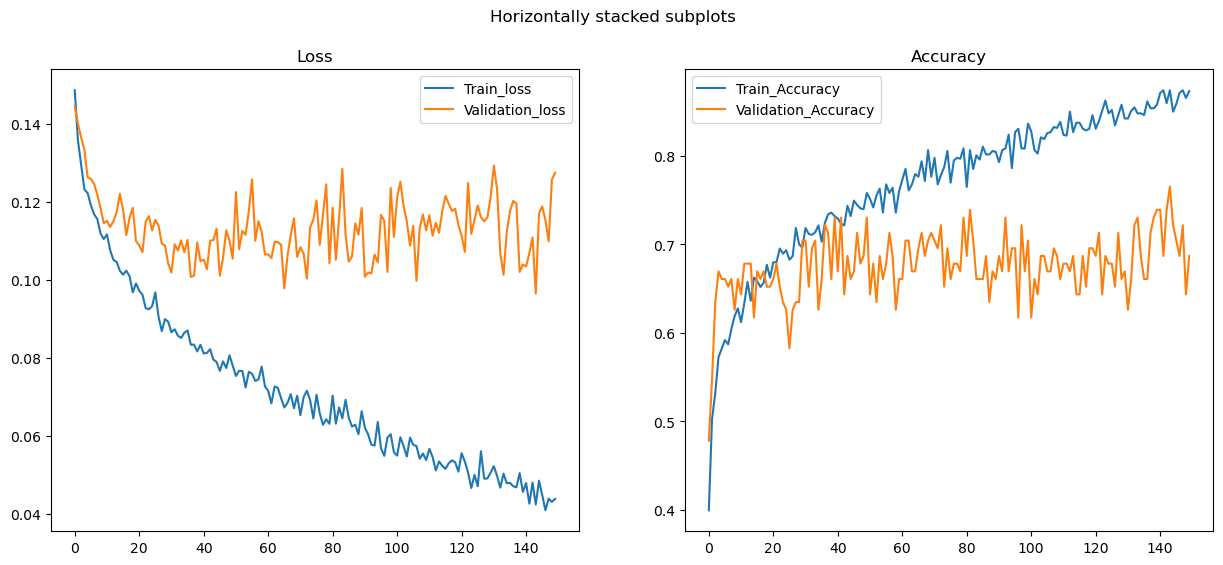

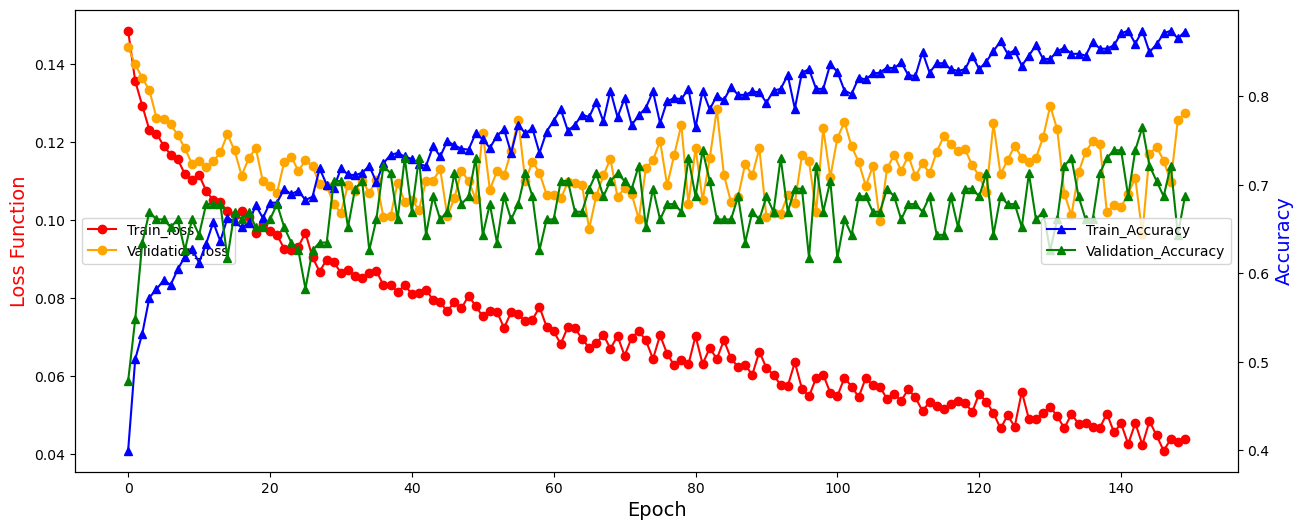

Current time: 277.807 minutes. Time expected till completion: 185.204 minutes
Epoch 151 of 250


100%|██████████| 15/15 [00:05<00:00,  2.97it/s]


train loss:  0.04543461260427244
Val loss:  0.12028635571832243
train accuracy:  0.8607350096711799
Val accuracy:  0.6695652173913044
Current time: 279.656 minutes. Time expected till completion: 183.351 minutes
Epoch 152 of 250


100%|██████████| 15/15 [00:05<00:00,  2.94it/s]


train loss:  0.04369235784535943
Val loss:  0.12470227434583332
train accuracy:  0.874274661508704
Val accuracy:  0.6956521739130435
Current time: 281.506 minutes. Time expected till completion: 181.497 minutes
Epoch 153 of 250


100%|██████████| 15/15 [00:05<00:00,  2.93it/s]


train loss:  0.04176472038088269
Val loss:  0.12270556539297103
train accuracy:  0.8820116054158608
Val accuracy:  0.7391304347826086
Current time: 283.356 minutes. Time expected till completion: 179.644 minutes
Epoch 154 of 250


100%|██████████| 15/15 [00:05<00:00,  2.94it/s]


train loss:  0.03876251416781654
Val loss:  0.11048436469357947
train accuracy:  0.8771760154738878
Val accuracy:  0.7391304347826086
Current time: 285.206 minutes. Time expected till completion: 177.791 minutes
Epoch 155 of 250


100%|██████████| 15/15 [00:05<00:00,  2.96it/s]


train loss:  0.03693587646407131
Val loss:  0.12897707340509995
train accuracy:  0.8887814313346228
Val accuracy:  0.6608695652173913
Current time: 287.056 minutes. Time expected till completion: 175.937 minutes
Epoch 156 of 250


100%|██████████| 15/15 [00:05<00:00,  2.93it/s]


train loss:  0.04542655308282352
Val loss:  0.11592797818391219
train accuracy:  0.8665377176015474
Val accuracy:  0.7565217391304347
Current time: 288.909 minutes. Time expected till completion: 174.086 minutes
Epoch 157 of 250


100%|██████████| 15/15 [00:05<00:00,  2.92it/s]


train loss:  0.04244429608752926
Val loss:  0.11413560328276261
train accuracy:  0.8723404255319149
Val accuracy:  0.7130434782608696
Current time: 290.760 minutes. Time expected till completion: 172.234 minutes
Epoch 158 of 250


100%|██████████| 15/15 [00:05<00:00,  2.96it/s]


train loss:  0.03815894592661461
Val loss:  0.12248442859753318
train accuracy:  0.8878143133462283
Val accuracy:  0.6869565217391305
Current time: 292.610 minutes. Time expected till completion: 170.380 minutes
Epoch 159 of 250


100%|██████████| 15/15 [00:05<00:00,  2.94it/s]


train loss:  0.04279542420369283
Val loss:  0.11084339398404826
train accuracy:  0.8829787234042553
Val accuracy:  0.7391304347826086
Current time: 294.459 minutes. Time expected till completion: 168.527 minutes
Epoch 160 of 250


100%|██████████| 15/15 [00:05<00:00,  2.94it/s]


train loss:  0.03734986093868024
Val loss:  0.1244985932889192
train accuracy:  0.8878143133462283
Val accuracy:  0.6956521739130435
Current time: 296.310 minutes. Time expected till completion: 166.674 minutes
Epoch 161 of 250


100%|██████████| 15/15 [00:05<00:00,  2.96it/s]


train loss:  0.041650404072793586
Val loss:  0.1094119967325874
train accuracy:  0.8762088974854932
Val accuracy:  0.7391304347826086
Current time: 298.159 minutes. Time expected till completion: 164.821 minutes
Epoch 162 of 250


100%|██████████| 15/15 [00:05<00:00,  2.95it/s]


train loss:  0.03820579896754868
Val loss:  0.11876860416453817
train accuracy:  0.8868471953578336
Val accuracy:  0.7130434782608696
Current time: 300.009 minutes. Time expected till completion: 162.968 minutes
Epoch 163 of 250


100%|██████████| 15/15 [00:05<00:00,  2.96it/s]


train loss:  0.04121062511531366
Val loss:  0.11180874899677608
train accuracy:  0.8810444874274661
Val accuracy:  0.7739130434782608
Current time: 301.859 minutes. Time expected till completion: 161.115 minutes
Epoch 164 of 250


100%|██████████| 15/15 [00:05<00:00,  2.95it/s]


train loss:  0.03992431511025249
Val loss:  0.11924792100553927
train accuracy:  0.8665377176015474
Val accuracy:  0.6956521739130435
Current time: 303.708 minutes. Time expected till completion: 159.261 minutes
Epoch 165 of 250


100%|██████████| 15/15 [00:05<00:00,  2.96it/s]


train loss:  0.04202450492655285
Val loss:  0.12502454571101976
train accuracy:  0.8781431334622823
Val accuracy:  0.6521739130434783
Current time: 305.557 minutes. Time expected till completion: 157.408 minutes
Epoch 166 of 250


100%|██████████| 15/15 [00:05<00:00,  2.96it/s]


train loss:  0.038069901299776374
Val loss:  0.12210437435170879
train accuracy:  0.8858800773694391
Val accuracy:  0.6695652173913044
Current time: 307.407 minutes. Time expected till completion: 155.555 minutes
Epoch 167 of 250


100%|██████████| 15/15 [00:05<00:00,  2.96it/s]


train loss:  0.0413279085342612
Val loss:  0.13888868495174075
train accuracy:  0.8665377176015474
Val accuracy:  0.6521739130434783
Current time: 309.255 minutes. Time expected till completion: 153.702 minutes
Epoch 168 of 250


100%|██████████| 15/15 [00:05<00:00,  2.95it/s]


train loss:  0.03911857495383437
Val loss:  0.1247952006433321
train accuracy:  0.8820116054158608
Val accuracy:  0.6782608695652174
Current time: 311.104 minutes. Time expected till completion: 151.848 minutes
Epoch 169 of 250


100%|██████████| 15/15 [00:05<00:00,  2.94it/s]


train loss:  0.039081505434929865
Val loss:  0.1356130835802659
train accuracy:  0.8810444874274661
Val accuracy:  0.6695652173913044
Current time: 312.953 minutes. Time expected till completion: 149.995 minutes
Epoch 170 of 250


100%|██████████| 15/15 [00:05<00:00,  2.94it/s]


train loss:  0.03522582817642555
Val loss:  0.11576573524786078
train accuracy:  0.9013539651837524
Val accuracy:  0.7391304347826086
Current time: 314.799 minutes. Time expected till completion: 148.141 minutes
Epoch 171 of 250


100%|██████████| 15/15 [00:05<00:00,  2.95it/s]


train loss:  0.03821928261615321
Val loss:  0.13544377580932948
train accuracy:  0.8810444874274661
Val accuracy:  0.6608695652173913
Current time: 316.645 minutes. Time expected till completion: 146.286 minutes
Epoch 172 of 250


100%|██████████| 15/15 [00:05<00:00,  2.93it/s]


train loss:  0.03808626145254136
Val loss:  0.13571794097838194
train accuracy:  0.8955512572533849
Val accuracy:  0.6782608695652174
Current time: 318.491 minutes. Time expected till completion: 144.432 minutes
Epoch 173 of 250


100%|██████████| 15/15 [00:05<00:00,  2.95it/s]


train loss:  0.036270433521651206
Val loss:  0.12678913564785668
train accuracy:  0.8887814313346228
Val accuracy:  0.6782608695652174
Current time: 320.337 minutes. Time expected till completion: 142.578 minutes
Epoch 174 of 250


100%|██████████| 15/15 [00:05<00:00,  2.96it/s]


train loss:  0.03670506520517444
Val loss:  0.12494809860768526
train accuracy:  0.8897485493230174
Val accuracy:  0.6695652173913044
Current time: 322.183 minutes. Time expected till completion: 140.724 minutes
Epoch 175 of 250


100%|██████████| 15/15 [00:05<00:00,  2.96it/s]


train loss:  0.03606299322091288
Val loss:  0.13233764210472937
train accuracy:  0.8800773694390716
Val accuracy:  0.6869565217391305
Current time: 324.029 minutes. Time expected till completion: 138.870 minutes
Epoch 176 of 250


100%|██████████| 15/15 [00:05<00:00,  2.97it/s]


train loss:  0.03740201568919121
Val loss:  0.13272365966568822
train accuracy:  0.879110251450677
Val accuracy:  0.6608695652173913
Current time: 325.875 minutes. Time expected till completion: 137.016 minutes
Epoch 177 of 250


100%|██████████| 15/15 [00:05<00:00,  2.97it/s]


train loss:  0.03809324823089333
Val loss:  0.11814440035301706
train accuracy:  0.8800773694390716
Val accuracy:  0.6782608695652174
Current time: 327.720 minutes. Time expected till completion: 135.161 minutes
Epoch 178 of 250


100%|██████████| 15/15 [00:05<00:00,  2.95it/s]


train loss:  0.0361271672656965
Val loss:  0.126197096835012
train accuracy:  0.8955512572533849
Val accuracy:  0.6869565217391305
Current time: 329.568 minutes. Time expected till completion: 133.308 minutes
Epoch 179 of 250


100%|██████████| 15/15 [00:05<00:00,  2.97it/s]


train loss:  0.0315788977489423
Val loss:  0.12640646158353142
train accuracy:  0.9013539651837524
Val accuracy:  0.7130434782608696
Current time: 331.414 minutes. Time expected till completion: 131.455 minutes
Epoch 180 of 250


100%|██████████| 15/15 [00:05<00:00,  2.94it/s]


train loss:  0.03669259105980166
Val loss:  0.1248976310958033
train accuracy:  0.8955512572533849
Val accuracy:  0.7043478260869566
Current time: 333.264 minutes. Time expected till completion: 129.603 minutes
Epoch 181 of 250


100%|██████████| 15/15 [00:05<00:00,  2.93it/s]


train loss:  0.035297345316012314
Val loss:  0.12509797118280244
train accuracy:  0.8974854932301741
Val accuracy:  0.6782608695652174
Current time: 335.114 minutes. Time expected till completion: 127.751 minutes
Epoch 182 of 250


100%|██████████| 15/15 [00:05<00:00,  2.94it/s]


train loss:  0.03247907301284935
Val loss:  0.1417507739170738
train accuracy:  0.90715667311412
Val accuracy:  0.6260869565217392
Current time: 336.965 minutes. Time expected till completion: 125.899 minutes
Epoch 183 of 250


100%|██████████| 15/15 [00:05<00:00,  2.94it/s]


train loss:  0.03459189316650539
Val loss:  0.1415192159621612
train accuracy:  0.9061895551257253
Val accuracy:  0.6521739130434783
Current time: 338.815 minutes. Time expected till completion: 124.047 minutes
Epoch 184 of 250


100%|██████████| 15/15 [00:05<00:00,  2.96it/s]


train loss:  0.03610642754060272
Val loss:  0.1257137835673664
train accuracy:  0.8916827852998066
Val accuracy:  0.6956521739130435
Current time: 340.665 minutes. Time expected till completion: 122.195 minutes
Epoch 185 of 250


100%|██████████| 15/15 [00:05<00:00,  2.93it/s]


train loss:  0.036674218554936015
Val loss:  0.12576136018918907
train accuracy:  0.8849129593810445
Val accuracy:  0.6869565217391305
Current time: 342.514 minutes. Time expected till completion: 120.343 minutes
Epoch 186 of 250


100%|██████████| 15/15 [00:05<00:00,  2.94it/s]


train loss:  0.033836809031096086
Val loss:  0.11805583847605663
train accuracy:  0.9061895551257253
Val accuracy:  0.7217391304347827
Current time: 344.360 minutes. Time expected till completion: 118.490 minutes
Epoch 187 of 250


100%|██████████| 15/15 [00:05<00:00,  2.93it/s]


train loss:  0.03643307280213332
Val loss:  0.14501513216806494
train accuracy:  0.8926499032882012
Val accuracy:  0.6608695652173913
Current time: 346.207 minutes. Time expected till completion: 116.637 minutes
Epoch 188 of 250


100%|██████████| 15/15 [00:05<00:00,  2.97it/s]


train loss:  0.03314502846010073
Val loss:  0.14861908710521202
train accuracy:  0.9081237911025145
Val accuracy:  0.7304347826086957
Current time: 348.053 minutes. Time expected till completion: 114.784 minutes
Epoch 189 of 250


100%|██████████| 15/15 [00:05<00:00,  2.98it/s]


train loss:  0.03215954029604764
Val loss:  0.14719751341187437
train accuracy:  0.9042553191489362
Val accuracy:  0.6695652173913044
Current time: 349.899 minutes. Time expected till completion: 112.930 minutes
Epoch 190 of 250


100%|██████████| 15/15 [00:05<00:00,  2.97it/s]


train loss:  0.03386669649023786
Val loss:  0.14645248586716858
train accuracy:  0.902321083172147
Val accuracy:  0.6782608695652174
Current time: 351.746 minutes. Time expected till completion: 111.078 minutes
Epoch 191 of 250


100%|██████████| 15/15 [00:05<00:00,  2.97it/s]


train loss:  0.027487267821133712
Val loss:  0.12783534157535303
train accuracy:  0.9226305609284333
Val accuracy:  0.7130434782608696
Current time: 353.592 minutes. Time expected till completion: 109.225 minutes
Epoch 192 of 250


100%|██████████| 15/15 [00:05<00:00,  2.96it/s]


train loss:  0.03516470192349741
Val loss:  0.13266555368900299
train accuracy:  0.8897485493230174
Val accuracy:  0.6956521739130435
Current time: 355.439 minutes. Time expected till completion: 107.372 minutes
Epoch 193 of 250


100%|██████████| 15/15 [00:05<00:00,  2.96it/s]


train loss:  0.03276584183660334
Val loss:  0.145936560695586
train accuracy:  0.9081237911025145
Val accuracy:  0.6695652173913044
Current time: 357.286 minutes. Time expected till completion: 105.520 minutes
Epoch 194 of 250


100%|██████████| 15/15 [00:05<00:00,  2.97it/s]


train loss:  0.032770724848229835
Val loss:  0.14809214084044747
train accuracy:  0.90715667311412
Val accuracy:  0.6782608695652174
Current time: 359.131 minutes. Time expected till completion: 103.667 minutes
Epoch 195 of 250


100%|██████████| 15/15 [00:05<00:00,  2.97it/s]


train loss:  0.03385906874038264
Val loss:  0.15582828936369522
train accuracy:  0.8936170212765957
Val accuracy:  0.7130434782608696
Current time: 360.978 minutes. Time expected till completion: 101.814 minutes
Epoch 196 of 250


100%|██████████| 15/15 [00:05<00:00,  2.98it/s]


train loss:  0.03352560609492619
Val loss:  0.13866072050903155
train accuracy:  0.9052224371373307
Val accuracy:  0.7043478260869566
Current time: 362.824 minutes. Time expected till completion: 99.962 minutes
Epoch 197 of 250


100%|██████████| 15/15 [00:05<00:00,  2.93it/s]


train loss:  0.02921002135545419
Val loss:  0.15571538780046545
train accuracy:  0.9177949709864603
Val accuracy:  0.6956521739130435
Current time: 364.670 minutes. Time expected till completion: 98.109 minutes
Epoch 198 of 250


100%|██████████| 15/15 [00:05<00:00,  2.96it/s]


train loss:  0.028512963481117724
Val loss:  0.14809565356244211
train accuracy:  0.9168278529980658
Val accuracy:  0.6521739130434783
Current time: 366.517 minutes. Time expected till completion: 96.257 minutes
Epoch 199 of 250


100%|██████████| 15/15 [00:05<00:00,  2.93it/s]


train loss:  0.031757743319413646
Val loss:  0.14049432407254758
train accuracy:  0.9148936170212766
Val accuracy:  0.6782608695652174
Current time: 368.363 minutes. Time expected till completion: 94.405 minutes
Epoch 200 of 250


100%|██████████| 15/15 [00:05<00:00,  2.96it/s]


train loss:  0.030909748965913943
Val loss:  0.14015590652175572
train accuracy:  0.90715667311412
Val accuracy:  0.6869565217391305
Saving model 1 checkpoint
Saving model 2 checkpoint


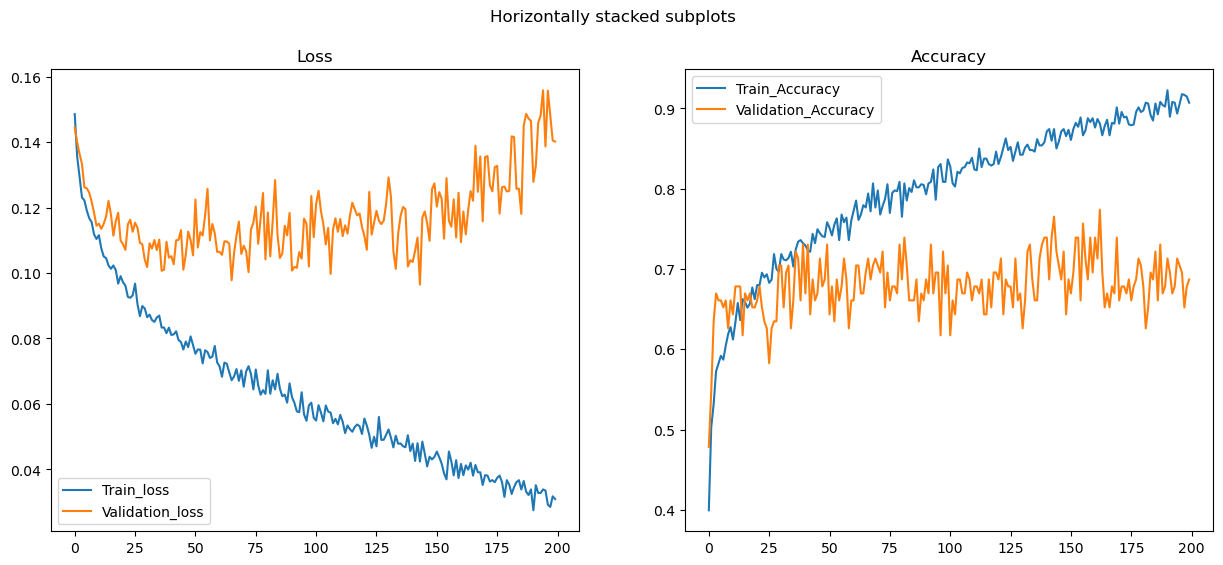

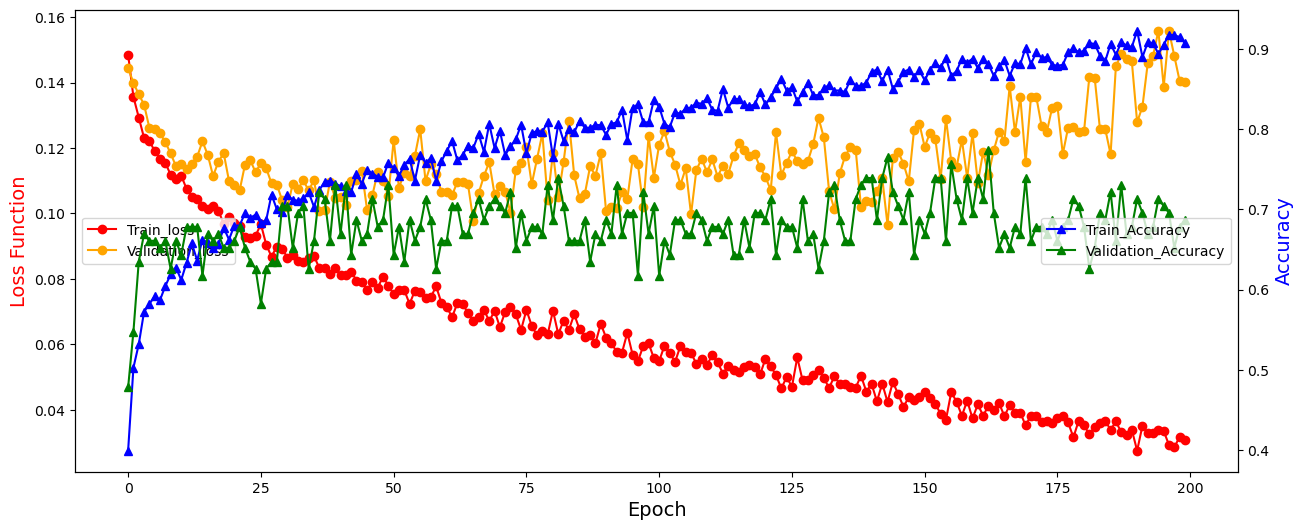

Current time: 370.286 minutes. Time expected till completion: 92.572 minutes
Epoch 201 of 250


100%|██████████| 15/15 [00:05<00:00,  2.95it/s]


train loss:  0.027820214511181735
Val loss:  0.141950656214486
train accuracy:  0.9177949709864603
Val accuracy:  0.7043478260869566
Current time: 372.135 minutes. Time expected till completion: 90.719 minutes
Epoch 202 of 250


100%|██████████| 15/15 [00:05<00:00,  2.96it/s]


train loss:  0.03760700264488071
Val loss:  0.12724094831425212
train accuracy:  0.8974854932301741
Val accuracy:  0.6782608695652174
Current time: 373.981 minutes. Time expected till completion: 88.867 minutes
Epoch 203 of 250


100%|██████████| 15/15 [00:05<00:00,  2.94it/s]


train loss:  0.027104786018943648
Val loss:  0.13129238337278365
train accuracy:  0.9323017408123792
Val accuracy:  0.7304347826086957
Current time: 375.827 minutes. Time expected till completion: 87.014 minutes
Epoch 204 of 250


100%|██████████| 15/15 [00:05<00:00,  2.95it/s]


train loss:  0.029086638033044176
Val loss:  0.1406407424937124
train accuracy:  0.9129593810444874
Val accuracy:  0.6782608695652174
Current time: 377.674 minutes. Time expected till completion: 85.162 minutes
Epoch 205 of 250


100%|██████████| 15/15 [00:05<00:00,  2.94it/s]


train loss:  0.03334506984702825
Val loss:  0.14176515230666037
train accuracy:  0.8945841392649904
Val accuracy:  0.6782608695652174
Current time: 379.520 minutes. Time expected till completion: 83.309 minutes
Epoch 206 of 250


100%|██████████| 15/15 [00:05<00:00,  2.97it/s]


train loss:  0.03281032099303874
Val loss:  0.14497921946256057
train accuracy:  0.9052224371373307
Val accuracy:  0.6782608695652174
Current time: 381.365 minutes. Time expected till completion: 81.457 minutes
Epoch 207 of 250


100%|██████████| 15/15 [00:05<00:00,  2.99it/s]


train loss:  0.032915595872057474
Val loss:  0.15190127789974212
train accuracy:  0.9042553191489362
Val accuracy:  0.6782608695652174
Current time: 383.210 minutes. Time expected till completion: 79.604 minutes
Epoch 208 of 250


100%|██████████| 15/15 [00:05<00:00,  2.97it/s]


train loss:  0.025630453549239
Val loss:  0.14529711267222528
train accuracy:  0.9294003868471954
Val accuracy:  0.7304347826086957
Current time: 385.056 minutes. Time expected till completion: 77.752 minutes
Epoch 209 of 250


100%|██████████| 15/15 [00:05<00:00,  2.97it/s]


train loss:  0.028581399065253237
Val loss:  0.13214273355577302
train accuracy:  0.9206963249516441
Val accuracy:  0.7043478260869566
Current time: 386.901 minutes. Time expected till completion: 75.899 minutes
Epoch 210 of 250


100%|██████████| 15/15 [00:05<00:00,  2.98it/s]


train loss:  0.03261734646829692
Val loss:  0.14338267314369263
train accuracy:  0.8974854932301741
Val accuracy:  0.7391304347826086
Current time: 388.747 minutes. Time expected till completion: 74.047 minutes
Epoch 211 of 250


100%|██████████| 15/15 [00:05<00:00,  2.96it/s]


train loss:  0.02783286178077443
Val loss:  0.13779131821964097
train accuracy:  0.9245647969052224
Val accuracy:  0.7478260869565218
Current time: 390.593 minutes. Time expected till completion: 72.195 minutes
Epoch 212 of 250


100%|██████████| 15/15 [00:05<00:00,  2.97it/s]


train loss:  0.029449545333388925
Val loss:  0.15741896694121155
train accuracy:  0.9226305609284333
Val accuracy:  0.6782608695652174
Current time: 392.440 minutes. Time expected till completion: 70.343 minutes
Epoch 213 of 250


100%|██████████| 15/15 [00:05<00:00,  2.97it/s]


train loss:  0.028858526051404744
Val loss:  0.15048333574896272
train accuracy:  0.9177949709864603
Val accuracy:  0.6608695652173913
Current time: 394.285 minutes. Time expected till completion: 68.491 minutes
Epoch 214 of 250


100%|██████████| 15/15 [00:05<00:00,  2.97it/s]


train loss:  0.0342215475350676
Val loss:  0.14655981530313905
train accuracy:  0.9168278529980658
Val accuracy:  0.7043478260869566
Current time: 396.131 minutes. Time expected till completion: 66.639 minutes
Epoch 215 of 250


100%|██████████| 15/15 [00:05<00:00,  2.96it/s]


train loss:  0.033929999319681575
Val loss:  0.1413723995504172
train accuracy:  0.9052224371373307
Val accuracy:  0.6695652173913044
Current time: 397.976 minutes. Time expected till completion: 64.787 minutes
Epoch 216 of 250


100%|██████████| 15/15 [00:05<00:00,  2.97it/s]


train loss:  0.03175470152080809
Val loss:  0.13739032110442287
train accuracy:  0.9052224371373307
Val accuracy:  0.6782608695652174
Current time: 399.823 minutes. Time expected till completion: 62.935 minutes
Epoch 217 of 250


100%|██████████| 15/15 [00:05<00:00,  2.95it/s]


train loss:  0.03204039545690126
Val loss:  0.14534433451683626
train accuracy:  0.9110251450676983
Val accuracy:  0.7130434782608696
Current time: 401.669 minutes. Time expected till completion: 61.083 minutes
Epoch 218 of 250


100%|██████████| 15/15 [00:05<00:00,  2.97it/s]


train loss:  0.03100603922023447
Val loss:  0.13819874188174372
train accuracy:  0.90715667311412
Val accuracy:  0.7130434782608696
Current time: 403.514 minutes. Time expected till completion: 59.231 minutes
Epoch 219 of 250


100%|██████████| 15/15 [00:05<00:00,  2.95it/s]


train loss:  0.028871321196828174
Val loss:  0.13449969129717868
train accuracy:  0.9274661508704062
Val accuracy:  0.7391304347826086
Current time: 405.361 minutes. Time expected till completion: 57.380 minutes
Epoch 220 of 250


100%|██████████| 15/15 [00:05<00:00,  2.95it/s]


train loss:  0.02915719469443569
Val loss:  0.13552729597558147
train accuracy:  0.9187620889748549
Val accuracy:  0.7217391304347827
Current time: 407.208 minutes. Time expected till completion: 55.528 minutes
Epoch 221 of 250


100%|██████████| 15/15 [00:05<00:00,  2.96it/s]


train loss:  0.029008994556286118
Val loss:  0.15250494279291318
train accuracy:  0.9197292069632496
Val accuracy:  0.6173913043478261
Current time: 409.054 minutes. Time expected till completion: 53.677 minutes
Epoch 222 of 250


100%|██████████| 15/15 [00:05<00:00,  2.96it/s]


train loss:  0.030525521251843157
Val loss:  0.13837040678962417
train accuracy:  0.9206963249516441
Val accuracy:  0.7217391304347827
Current time: 410.900 minutes. Time expected till completion: 51.825 minutes
Epoch 223 of 250


100%|██████████| 15/15 [00:05<00:00,  2.97it/s]


train loss:  0.028774289174700728
Val loss:  0.15512071504541067
train accuracy:  0.9119922630560928
Val accuracy:  0.7043478260869566
Current time: 412.744 minutes. Time expected till completion: 49.974 minutes
Epoch 224 of 250


100%|██████████| 15/15 [00:05<00:00,  2.98it/s]


train loss:  0.02748896647244692
Val loss:  0.15835269566463386
train accuracy:  0.9226305609284333
Val accuracy:  0.7043478260869566
Current time: 414.589 minutes. Time expected till completion: 48.122 minutes
Epoch 225 of 250


100%|██████████| 15/15 [00:05<00:00,  2.96it/s]


train loss:  0.030352419474643136
Val loss:  0.15981922408808832
train accuracy:  0.9226305609284333
Val accuracy:  0.6347826086956522
Current time: 416.434 minutes. Time expected till completion: 46.270 minutes
Epoch 226 of 250


100%|██████████| 15/15 [00:05<00:00,  2.95it/s]


train loss:  0.029369977256012956
Val loss:  0.1579633417336837
train accuracy:  0.9110251450676983
Val accuracy:  0.6521739130434783
Current time: 418.280 minutes. Time expected till completion: 44.419 minutes
Epoch 227 of 250


100%|██████████| 15/15 [00:05<00:00,  2.97it/s]


train loss:  0.02633402837220601
Val loss:  0.13920487929945408
train accuracy:  0.925531914893617
Val accuracy:  0.6956521739130435
Current time: 420.126 minutes. Time expected till completion: 42.568 minutes
Epoch 228 of 250


100%|██████████| 15/15 [00:05<00:00,  2.95it/s]


train loss:  0.02742225270739953
Val loss:  0.14978243993676227
train accuracy:  0.9303675048355899
Val accuracy:  0.6521739130434783
Current time: 421.973 minutes. Time expected till completion: 40.717 minutes
Epoch 229 of 250


100%|██████████| 15/15 [00:05<00:00,  2.96it/s]


train loss:  0.02849481202755664
Val loss:  0.15132001534752224
train accuracy:  0.9235976789168279
Val accuracy:  0.6695652173913044
Current time: 423.818 minutes. Time expected till completion: 38.865 minutes
Epoch 230 of 250


100%|██████████| 15/15 [00:05<00:00,  2.97it/s]


train loss:  0.02731509747008867
Val loss:  0.1670535744532295
train accuracy:  0.9274661508704062
Val accuracy:  0.6347826086956522
Current time: 425.665 minutes. Time expected till completion: 37.014 minutes
Epoch 231 of 250


100%|██████████| 15/15 [00:05<00:00,  2.97it/s]


train loss:  0.028084314372426537
Val loss:  0.14362004528874936
train accuracy:  0.9197292069632496
Val accuracy:  0.7304347826086957
Current time: 427.511 minutes. Time expected till completion: 35.163 minutes
Epoch 232 of 250


100%|██████████| 15/15 [00:05<00:00,  2.97it/s]


train loss:  0.024729803078438604
Val loss:  0.14574928730726242
train accuracy:  0.9323017408123792
Val accuracy:  0.7130434782608696
Current time: 429.356 minutes. Time expected till completion: 33.312 minutes
Epoch 233 of 250


100%|██████████| 15/15 [00:05<00:00,  2.97it/s]


train loss:  0.028410787395124162
Val loss:  0.13089849592550942
train accuracy:  0.913926499032882
Val accuracy:  0.7217391304347827
Current time: 431.201 minutes. Time expected till completion: 31.461 minutes
Epoch 234 of 250


100%|██████████| 15/15 [00:05<00:00,  2.98it/s]


train loss:  0.028688115613603498
Val loss:  0.13962094135906386
train accuracy:  0.9197292069632496
Val accuracy:  0.7304347826086957
Current time: 433.045 minutes. Time expected till completion: 29.610 minutes
Epoch 235 of 250


100%|██████████| 15/15 [00:05<00:00,  2.95it/s]


train loss:  0.024456292359298904
Val loss:  0.14855154286260192
train accuracy:  0.9313346228239845
Val accuracy:  0.7130434782608696
Current time: 434.892 minutes. Time expected till completion: 27.759 minutes
Epoch 236 of 250


100%|██████████| 15/15 [00:05<00:00,  2.97it/s]


train loss:  0.027099068872846764
Val loss:  0.14239356219768523
train accuracy:  0.9226305609284333
Val accuracy:  0.7304347826086957
Current time: 436.736 minutes. Time expected till completion: 25.908 minutes
Epoch 237 of 250


100%|██████████| 15/15 [00:05<00:00,  2.97it/s]


train loss:  0.026247812799813957
Val loss:  0.1293105151342309
train accuracy:  0.9342359767891683
Val accuracy:  0.7478260869565218
Current time: 438.582 minutes. Time expected till completion: 24.057 minutes
Epoch 238 of 250


100%|██████████| 15/15 [00:05<00:00,  2.96it/s]


train loss:  0.02394118880658506
Val loss:  0.13918102577976557
train accuracy:  0.9303675048355899
Val accuracy:  0.6956521739130435
Current time: 440.428 minutes. Time expected till completion: 22.206 minutes
Epoch 239 of 250


100%|██████████| 15/15 [00:05<00:00,  2.96it/s]


train loss:  0.02457147135491153
Val loss:  0.1409863619700722
train accuracy:  0.9352030947775629
Val accuracy:  0.7217391304347827
Current time: 442.274 minutes. Time expected till completion: 20.356 minutes
Epoch 240 of 250


100%|██████████| 15/15 [00:05<00:00,  2.95it/s]


train loss:  0.02630262083429807
Val loss:  0.14724801837102228
train accuracy:  0.925531914893617
Val accuracy:  0.6869565217391305
Current time: 444.121 minutes. Time expected till completion: 18.505 minutes
Epoch 241 of 250


100%|██████████| 15/15 [00:05<00:00,  2.94it/s]


train loss:  0.030314201931334037
Val loss:  0.13870096673136173
train accuracy:  0.9352030947775629
Val accuracy:  0.7391304347826086
Current time: 445.966 minutes. Time expected till completion: 16.654 minutes
Epoch 242 of 250


100%|██████████| 15/15 [00:05<00:00,  2.95it/s]


train loss:  0.03145907711907789
Val loss:  0.10558364708786426
train accuracy:  0.9187620889748549
Val accuracy:  0.7565217391304347
Current time: 447.812 minutes. Time expected till completion: 14.804 minutes
Epoch 243 of 250


100%|██████████| 15/15 [00:05<00:00,  2.94it/s]


train loss:  0.02577833218294659
Val loss:  0.12932389002779257
train accuracy:  0.9245647969052224
Val accuracy:  0.7565217391304347
Current time: 449.661 minutes. Time expected till completion: 12.953 minutes
Epoch 244 of 250


100%|██████████| 15/15 [00:05<00:00,  2.96it/s]


train loss:  0.022516154896691298
Val loss:  0.15403688912806304
train accuracy:  0.9332688588007737
Val accuracy:  0.7391304347826086
Current time: 451.510 minutes. Time expected till completion: 11.103 minutes
Epoch 245 of 250


100%|██████████| 15/15 [00:05<00:00,  2.96it/s]


train loss:  0.025266994914937065
Val loss:  0.1282830975625826
train accuracy:  0.9274661508704062
Val accuracy:  0.7391304347826086
Current time: 453.358 minutes. Time expected till completion: 9.252 minutes
Epoch 246 of 250


100%|██████████| 15/15 [00:05<00:00,  2.96it/s]


train loss:  0.02970793721224659
Val loss:  0.12584785067516824
train accuracy:  0.9235976789168279
Val accuracy:  0.7130434782608696
Current time: 455.205 minutes. Time expected till completion: 7.402 minutes
Epoch 247 of 250


100%|██████████| 15/15 [00:05<00:00,  2.96it/s]


train loss:  0.027645568776789267
Val loss:  0.14420952084271804
train accuracy:  0.913926499032882
Val accuracy:  0.6869565217391305
Current time: 457.052 minutes. Time expected till completion: 5.551 minutes
Epoch 248 of 250


100%|██████████| 15/15 [00:05<00:00,  2.97it/s]


train loss:  0.024459322242109498
Val loss:  0.12145763026631397
train accuracy:  0.9284332688588007
Val accuracy:  0.7304347826086957
Current time: 458.899 minutes. Time expected till completion: 3.701 minutes
Epoch 249 of 250


100%|██████████| 15/15 [00:05<00:00,  2.97it/s]


train loss:  0.0254804651717686
Val loss:  0.12315769908220872
train accuracy:  0.9313346228239845
Val accuracy:  0.7652173913043478
Current time: 460.745 minutes. Time expected till completion: 1.850 minutes
Epoch 250 of 250


100%|██████████| 15/15 [00:05<00:00,  2.97it/s]


train loss:  0.022285869010909672
Val loss:  0.1363160182600436
train accuracy:  0.9458413926499033
Val accuracy:  0.6782608695652174
Saving model 1 checkpoint
Saving model 2 checkpoint


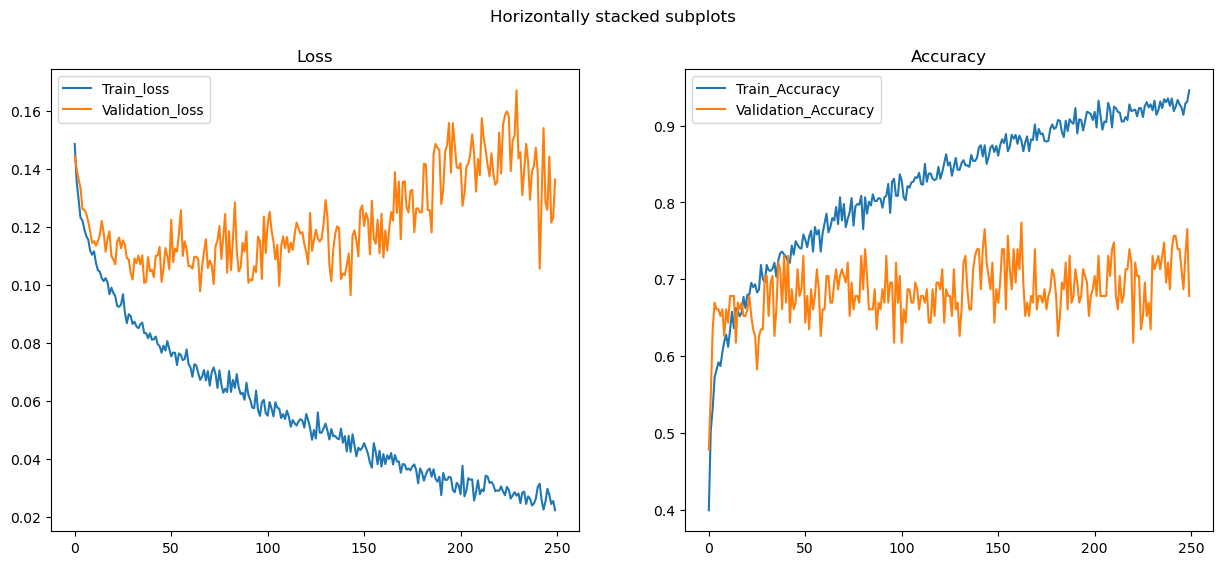

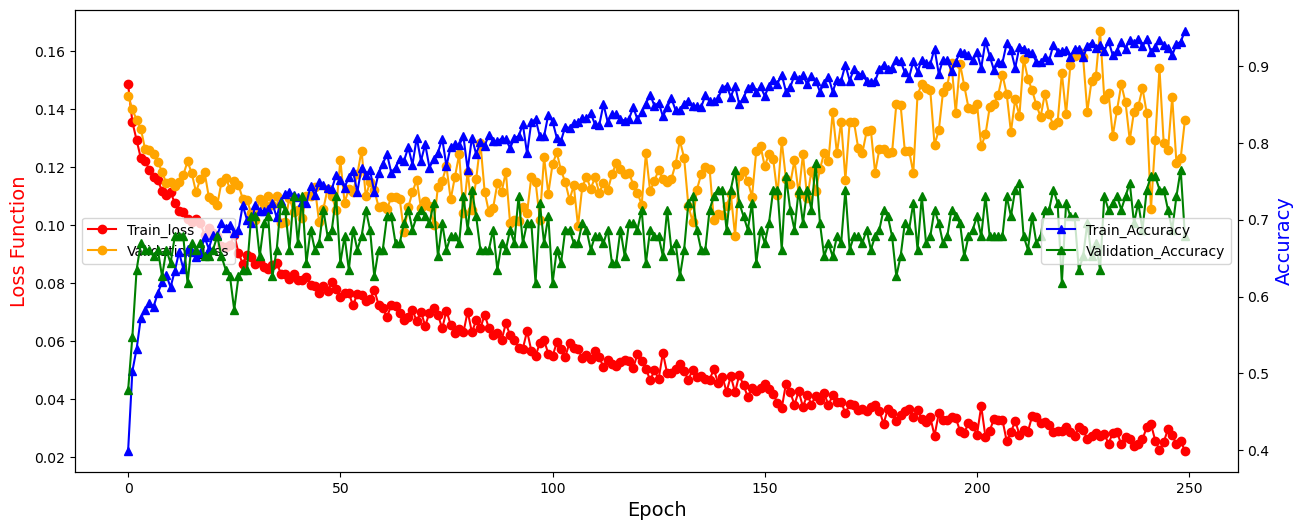

Current time: 462.679 minutes. Time expected till completion: 0.000 minutes
Finished training in: 462.679 minutes


In [24]:

train_loss, val_loss = [], []
train_accuracy, val_accuracy = [], []

# Load checkpoints
names = os.listdir(model_checkpoints)
for elem in names:
    if(elem=="metrics_losss_accuracy_m2.csv"):
        print("Loading Metrics")
        dd = pd.read_csv(model_checkpoints + "metrics_losss_accuracy_m2.csv")
        train_loss = dd["train_loss"].tolist()
        val_loss = dd["val_loss"].tolist()
        train_accuracy = dd["train_accuracy"].tolist()
        val_accuracy = dd["val_accuracy"].tolist()
        
        
# count time
start = time.time()

for epoch in range(model_epoch_m2_check, model_epochs):
    # Print current epoch
    print(f"Epoch {epoch + 1} of {model_epochs}")
    
    if(epoch%10 == 0):
        update_optimizer(optimizer, 0.001)
        update_optimizer(optimizer_2, 0.001)
    
    ############################################################################
    ################################ Train model ############################### 
    ############################################################################
    model_bbox.train()
    modelpy.train()
    running_loss=0
    total=0
    correct=0
    # loop for every training batch (one epoch)
    for bi, data in tqdm(enumerate(train_loader), total=len(train_loader)): # use tqdm package to track running time
        # Get the tensors
        images = data[0].to(device)# use the gpu
        labels = data[1].to(device)# use the gpu
        
        
        #create the output from the CNN base on the give batch images
        out = model_bbox(images)
        # count the loss function 
        loss_1 = criterion(out, labels)
        
        # Set the model to evaluation only
        model_bbox.eval()
        # Use model_bbox model to get the new cropped images basen on CAM
        new_images = get_cropped_img_batch_base_on_CAM(images, device, cam, threshold = BBOX_THRESHOLD).to(device)
        # Set the model to train only
        model_bbox.train()
        
        
        
        
        # Optimize second model
        
        #create the output from the CNN base on the give batch images
        out_m2 = modelpy(new_images)
        # count the loss function 
        loss_2 = criterion_2(out_m2, labels)
        
        total_loss = loss_1 + loss_2
        
        # BackPropagate on model 1
        ######################
        optimizer.zero_grad()
        ######################
        # count the backpropagation
        total_loss.backward(retain_graph=True)
        # learning
        optimizer.step()
        
        
        # BackPropagate on model 2
        ######################
        optimizer_2.zero_grad()
        ######################
        # count the backpropagation
        loss_2.backward()
        # learning
        optimizer_2.step()
        
        
        
        
        # add new value to the main loss
        running_loss += loss_2.item()
        
        # calculate accuracy
        predictions = torch.argmax(out_m2, dim=1)
        total += labels.size(0)
        correct +=(predictions == labels).sum().item()
        
        
    train_epoch_loss = running_loss/len(train_loader.dataset)
    
    train_epoch_accuracy = correct/total
    
    ############################################################################
    ################################ Eval model ################################ 
    ############################################################################
    model_bbox.eval()
    modelpy.eval()
    running_loss = 0.0
    correct=0
    total=0
    #with torch.no_grad():
    for bi, data in tqdm(enumerate(valid_loader), total=len(valid_loader)):
            # Get the tensors
            images = data[0].to(device)# use the gpu
            label = data[1].to(device)# use the gpu
            
            
            # Use model_bbox model to get the new cropped images basen on CAM
            new_images = get_cropped_img_batch_base_on_CAM(images, device, cam, threshold = BBOX_THRESHOLD).to(device)
            
            with torch.no_grad():
                #create the output from the CNN base on the give batch images
                outputs = modelpy(new_images)
                # count the loss function
                loss = criterion_2(outputs, label)
            
            # Add loss of each item (total items in a batch = batch size) .
            running_loss += loss.item()
            
            # calculate accuracy
            predictions = torch.argmax(outputs, dim=1)
            total += label.size(0)
            correct +=(predictions == label).sum().item()
            
    val_epoch_loss = running_loss/len(valid_loader.dataset) 
    val_epoch_accuracy = correct/total
    
    
    print("train loss: ", train_epoch_loss)
    print("Val loss: ", val_epoch_loss)
    print("train accuracy: ", train_epoch_accuracy)
    print("Val accuracy: ", val_epoch_accuracy)

    
    # save results
    train_loss.append(train_epoch_loss)
    val_loss.append(val_epoch_loss)
    train_accuracy.append(train_epoch_accuracy)
    val_accuracy.append(val_epoch_accuracy)
    
    
    # Save model with all information every 100 epochs. Can be used 
    # resuming training. optim
    if (epoch+1) % checkpoints_save == 0: # checkpoints_save
        # Save Model
        print("Saving model 1 checkpoint")
        end = time.time()
        time_elapsed = (end-start)+previous_time
        
        save_model(epoch, time_elapsed, model_bbox, optimizer, criterion, path = model_checkpoints + "model_ckpt_m1.pth")
        # save model at epoch
        save_model(epoch, time_elapsed, model_bbox, optimizer, criterion, path = model_checkpoints + "model_ckpt_m1_"+str(epoch+1)+".pth")
        
        # Save Model
        print("Saving model 2 checkpoint")
        save_model(epoch, time_elapsed, modelpy, optimizer_2, criterion_2, path = model_checkpoints + "model_ckpt_m2.pth")
        # save the metrics
        save_metrics(train_loss, val_loss, train_accuracy, val_accuracy, path = model_checkpoints + "metrics_losss_accuracy_m2.csv")
        
        # save model at epoch
        save_model(epoch, time_elapsed, modelpy, optimizer_2, criterion_2, path = model_checkpoints + "model_ckpt_m2_"+str(epoch+1)+".pth")
        
        
        # Cheack the evolution at this point
        plot_loss_accuracy(train_loss, val_loss, train_accuracy, val_accuracy)
        
        
    ep_time = time.time()
    print(f"Current time: {(((ep_time-start)+previous_time)/60):.3f} minutes. Time expected till completion: {(((((ep_time-start)+previous_time)/(epoch + 1)) * (model_epochs-(epoch + 1)))/60):.3f} minutes")
    
end = time.time()
print(f"Finished training in: {(((end-start)+previous_time)/60):.3f} minutes") 

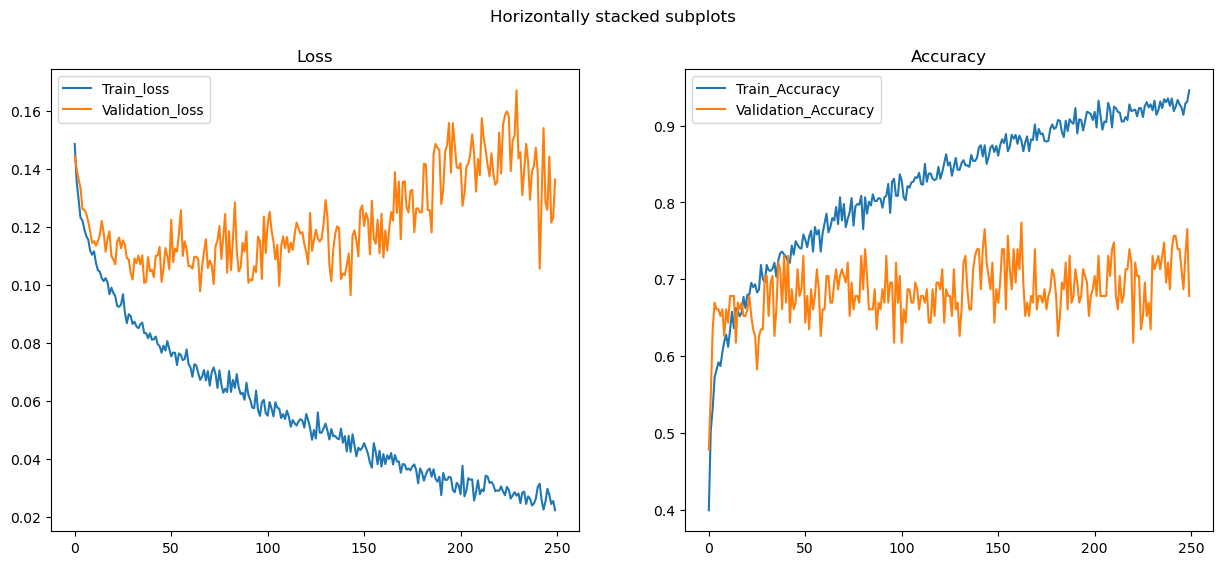

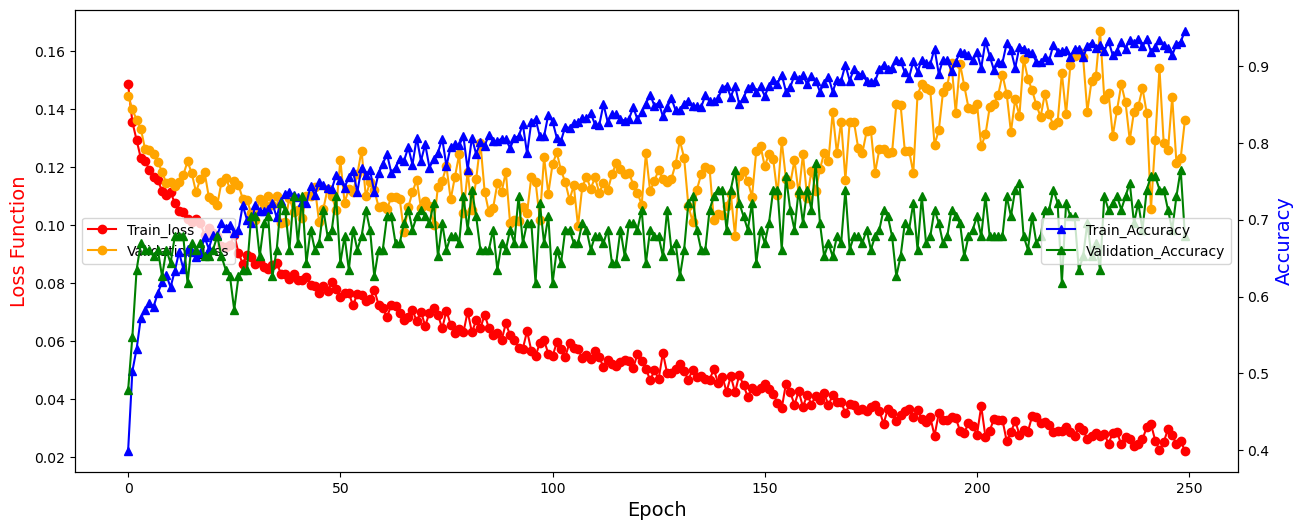

In [25]:
plot_loss_accuracy(train_loss, val_loss, train_accuracy, val_accuracy)

# Save Model

In [26]:
# Save Model
NAME = "model_1.pt"
NAME2 = "model_2.pt"

torch.save(model_bbox.state_dict(), PATH+NAME)
torch.save(modelpy.state_dict(), PATH+NAME2)

# Load Models

In [27]:
#model_bbox = Model_BBOX().to(device)
# Load the model
NAME = "model_1.pt"
model_bbox.load_state_dict(torch.load(PATH+NAME, map_location=device))
model_bbox.eval()



#modelpy = ClassificationNet().to(device)
# Load the model
NAME = "model_2.pt"
modelpy.load_state_dict(torch.load(PATH+NAME, map_location=device))
modelpy.eval()

ClassificationNet(
  (googlenet): GoogLeNet(
    (conv1): BasicConv2d(
      (conv): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
    )
    (maxpool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
    (conv2): BasicConv2d(
      (conv): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
    )
    (conv3): BasicConv2d(
      (conv): Conv2d(64, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn): BatchNorm2d(192, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
    )
    (maxpool2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
    (inception3a): Inception(
      (branch1): BasicConv2d(
        (conv): Conv2d(192, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
   

# Evaluate model

In [28]:
  
def accuracy_given_set(mm1, mm2, valid_loader, cam, device, name="Validation"):
    # Evaluate the Validation Set
    mm1.eval()
    mm2.eval()
    correct = 0
    total = 0
    for bi, data in tqdm(enumerate(valid_loader), total=len(valid_loader)):
        # Use model_bbox model to get the new cropped images basen on CAM
        new_images = get_cropped_img_batch_base_on_CAM(data[0].to(device), device, cam, threshold = BBOX_THRESHOLD).to(device)
        
        with torch.no_grad():
            
            outputs = mm2(new_images)
            predictions = torch.argmax(outputs, dim=1)

        total += data[1].size(0)
        correct +=(predictions == data[1].to(device)).sum().item()
        
    print(f'Accuracy of the network on the {total} {name} instances: {100 * correct / total}%')

In [29]:
# Calculate accuracy for Validation and Train sets
accuracy_given_set(model_bbox, modelpy, train_loader, cam, device, name="Train")
accuracy_given_set(model_bbox, modelpy, valid_loader, cam, device, name="Validation")

100%|██████████| 130/130 [00:44<00:00,  2.91it/s]


Accuracy of the network on the 1034 Train instances: 97.38878143133462%


100%|██████████| 15/15 [00:05<00:00,  2.96it/s]

Accuracy of the network on the 115 Validation instances: 67.82608695652173%


# Plot images and Bbox

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Img shape: (224, 224, 3)
Bbox pred: [ 60.  73. 132. 138.]
Label real: 1
Size of img: (224, 224, 3)


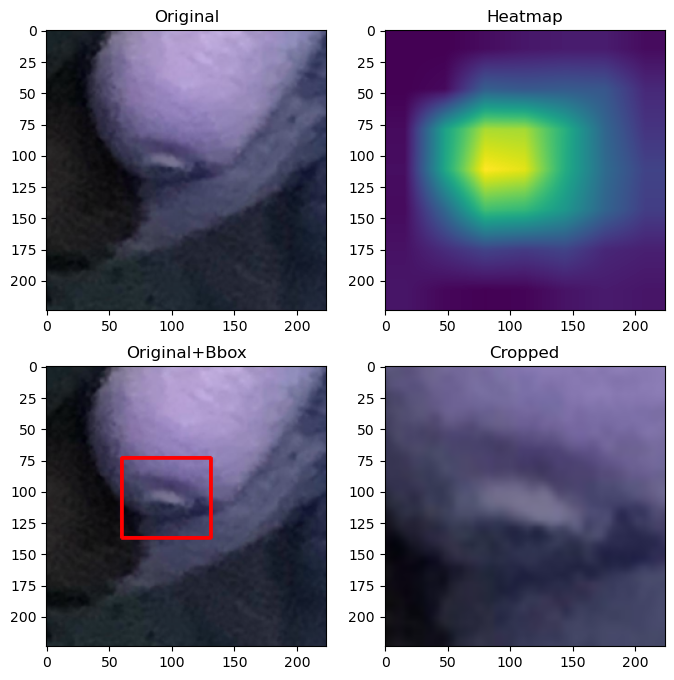

In [30]:
img_number = 1
# Create heatmap and Bbox
real_img, real_label, pred_heat, pred_box =get_true_values_and_predictions(model_bbox, val_Dataset, img_number, cam, threshold=BBOX_THRESHOLD)
# Compose img of real img+Bbox and croped Image
rr, rr_crop = create_img_and_bbox_with_pred(real_img, pred_box)

# Plot
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2,figsize=(8,8))
ax1.imshow(real_img)
ax1.title.set_text("Original")
ax2.imshow(pred_heat)
ax2.title.set_text("Heatmap")
ax3.imshow(rr)
ax3.title.set_text("Original+Bbox")
ax4.imshow(rr_crop)
ax4.title.set_text("Cropped")
plt.show()

# Make Test Predictions

In [31]:
# Import the data into a resized 224x224 images
size_of_resized_img = (275, 275) 
test_data, test_labels = import_test_folder_dataset(test_data_path, resized_side=size_of_resized_img)
print("Dim of Data: ", test_data.shape)
print("Dim of Lables: ", test_labels.shape)

Dim of Data:  (380, 275, 275, 3)
Dim of Lables:  (380,)


In [32]:
# Create the dataset object
test_Dataset = Data_test(test_data, test_labels, img_transform_val) # img_transform_2 img_transform

print("Test len: ",len(test_Dataset))

Test len:  380


In [33]:
# Create the dataloaders
test_loader = DataLoader(
    test_Dataset, 
    batch_size=1,             
    shuffle=False)

In [34]:
 
def make_predictions(mm1, mm2, loader, cam, device):
    # Evaluate the Validation Set
    mm1.eval()
    mm2.eval()
    predictions_list = []
    name_list = []
    for bi, data in tqdm(enumerate(loader), total=len(loader)):
        # Use model_bbox model to get the new cropped images basen on CAM
        new_images = get_cropped_img_batch_base_on_CAM(data[0].to(device), device, cam, threshold = BBOX_THRESHOLD).to(device)
            
        with torch.no_grad():
            
            outputs = mm2(new_images)
            predictions = torch.argmax(outputs, dim=1)
        
        predictions_list.append(predictions[0].item())
        name_list.append(data[1][0])
    return(predictions_list, name_list)

In [35]:
pred, names = make_predictions(model_bbox, modelpy, test_loader, cam, device)

np.unique(np.array(pred),return_counts=True)

100%|██████████| 380/380 [00:29<00:00, 12.79it/s]


(array([0, 1, 2, 3]), array([164, 167,  47,   2], dtype=int64))

In [36]:
save_predictions_as_csv(names, pred, name="grad-CAM_bbox_plus_clas_v8_prediction.csv")

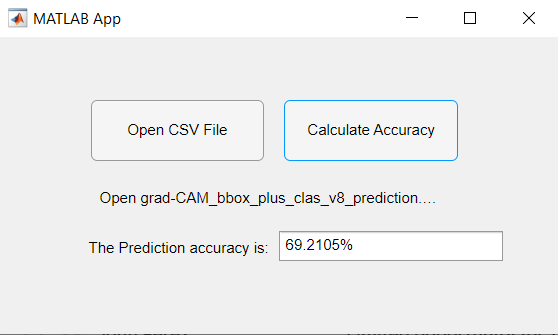